# Modal organization in Chinese Folks songs
-----------
## Digital Musicology - Milestone 3
-------

In [1]:
# Imports 

from music21 import *
import glob
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter, OrderedDict
import networkx as nx
import math
from fractions import Fraction

# Users should modify the MuseScore_PATH with the path to MuseScore on their own device

MuseScore_PATH = 'C:\Program Files\MuseScore3\\bin\\MuseScore3.exe'

environment.set('musescoreDirectPNGPath', MuseScore_PATH)

### Score Loading

In [2]:
regions = ["han", "natmin", "shanxi", "xinhua"]
# The manually annotated geographic divisions
geo_divisions = ["Northwest", "Central", "Southwest", "Northeast", "Jiangzhe", "Southeast", "Neimeng", "Jiang"]

We then define the function below that returns all *\*\*kern* scores in the given `path`, parsed with `music21`'s function.

In [3]:
def load_scores(path):
    """
    The function accepts a path and loads the .krn files in the path into a list.
    The pieces that are successfully parsed by the music21 parsers are stored in the scores list.
    In case the parser fails to load any file, they are stored in failed_scores.
    The count of total scores and failed scores are stores in total and failed counters.
    """

    pieces = {"scores": [], "failed_scores": [], "total": 0, "failed": 0}
    for file in tqdm(glob.glob(path+"/*.krn")):
        pieces["total"] += 1
        try:
            pieces["scores"].append(converter.parse(file))
        except:
            pieces["failed"] += 1 
            pieces["failed_scores"].append(converter.parse(file))

    return pieces

We can now iterate over the four regions, also corresponding to the four folders, and use the `load_score` function defined above to retrieve all scores of our dataset.

In [4]:
# A dictionary to store the music scores belonging to the 4 regions of the CFS as per the dataset.
# The key is the name of the region and the value is dictionay with keys corresponding to scores,
# failed_scores - Representing scores that have not loaded properly,
# total - representing the total number of scores of that region and failed - representing the total number of scores that have failed to be parsed.

music_data = {}

for region in regions:
    music_data[region] = load_scores("./data/" + region)

100%|██████████| 10/10 [00:00<00:00, 108.69it/s]


### Methods

we define our regional categories using the following map and call them geographical divisions:

![map](img/map.JPG)

In [5]:
CFS_full = pd.read_csv("./data/dataframes/cfs_full.csv", converters={'pitches': eval,'pitchclasses': eval,'pitches_transposed': eval,'pitchclasses_transposed': eval,'top5_after_transpose': eval})
CFS_full.head()

,region,title,location,tonic,pitches,num_notes,pitchclasses,num_pitchclasses,tonic_transposed,pitches_transposed,pitchclasses_transposed,top5_after_transpose,mode,geo_division
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...",64,"[D, A, C, G, E, F#]",6,C,"[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, F, D, E]","[C, B-, F, G, D]",shang,Northwest
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...",57,"[C, F, B-, G, E-, D, A]",7,C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, F, B-, G, E-, D, A]","[C, G, F, E-, D]",NaN,Northwest
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...",24,"[D, A, G, E, B]",5,C,"[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, F, D, A]","[C, G, F, D, A]",zhi,Northwest
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...",41,"[E-, C, B-, A-, F]",5,C,"[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, G]","[C, F, G, B-, D]",shang,Northwest
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...",24,"[E, A, G, B, D]",5,C,"[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, F, E-, G, B-]","[C, G, F, B-, E-]",yu,Northwest


## Exploring regional differences

In [6]:
pitch_classes_list = ['A', 'A#', 'A-', 'B', 'B#', 'B-', 'C', 'C#', 'C-', 'D', 'D#', 'D-', 'E', 'E#', 'E-', 'F', 'F#', 'G', 'G#', 'G-']
music_interval_list = ['A1','A2','A3','A4','A5','A6','A7','P1','P4','P5','P8','m2','M2','m3','M3','m6','M6','m7','M7',"d2","d3","d4","d5","d6","d7","d8"]

scaledegree_defcount = {pc:0 for pc in pitch_classes_list}
pitchclass_transitions_defcount = {pc1:{pc2:0 for pc2 in pitch_classes_list} for pc1 in pitch_classes_list}
interval_transitions_defcount = {pc:0 for pc in music_interval_list}

### Pitch statistics (without metrical information)

In this subsection, we plot the combined pitch and scale degrees distributions of all the pieces combined for each division.

To do so, we first create empty dictionaries to store the pitches and scale degrees before and after transposition with division name as key and values as a list of pitches/scale degrees of all pieces belonging to that division.

In [7]:
# Empty dictionaries to store pitches and 
region_pitch_stat = {}
region_scaledegree_stat = {}
region_pitch_transposed_stat = {}
region_scaledegree_transposed_stat = {}
region_tonic_stat = {}

for gloc in geo_divisions: 
    region_df = CFS_full[CFS_full["geo_division"]==gloc]
    region_pitch_stat[gloc] = sum(region_df["pitches"].tolist(), [])
    region_scaledegree_stat[gloc] = sum(region_df["pitchclasses"].tolist(), [])
    region_pitch_transposed_stat[gloc] = sum(region_df["pitches_transposed"].tolist(), [])
    region_scaledegree_transposed_stat[gloc] = sum(region_df["pitchclasses_transposed"].tolist(), [])
    region_tonic_stat[gloc] = region_df["tonic"].tolist()

The pitch distribution can then be computed by counting the occurrence of each pitch. This distribution can then be shown with a bar plot.

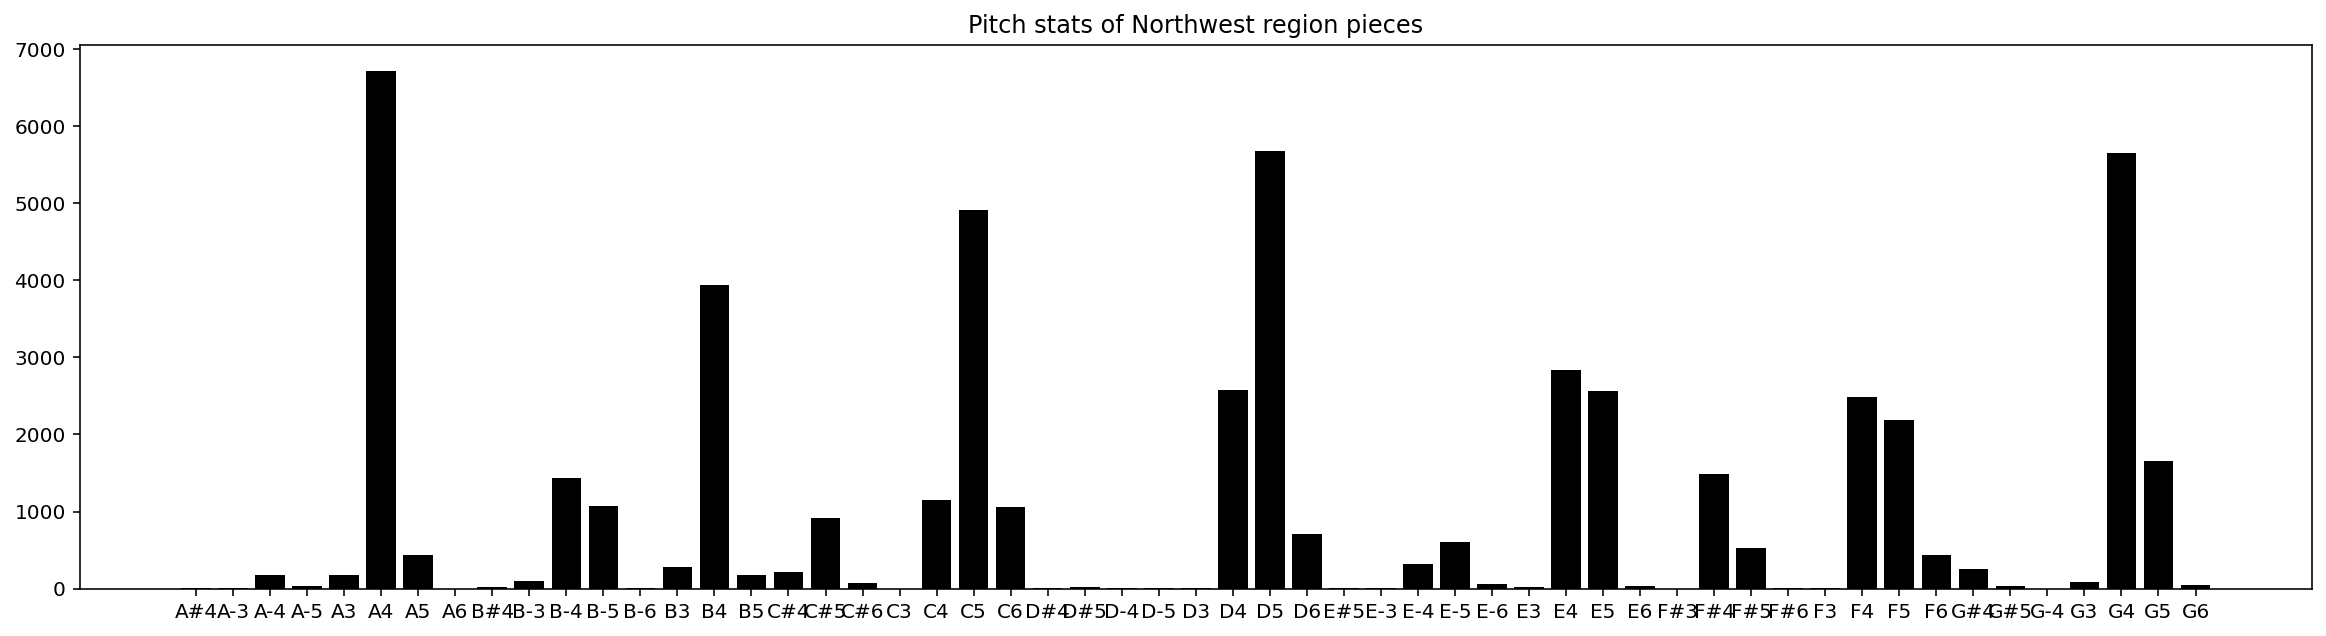

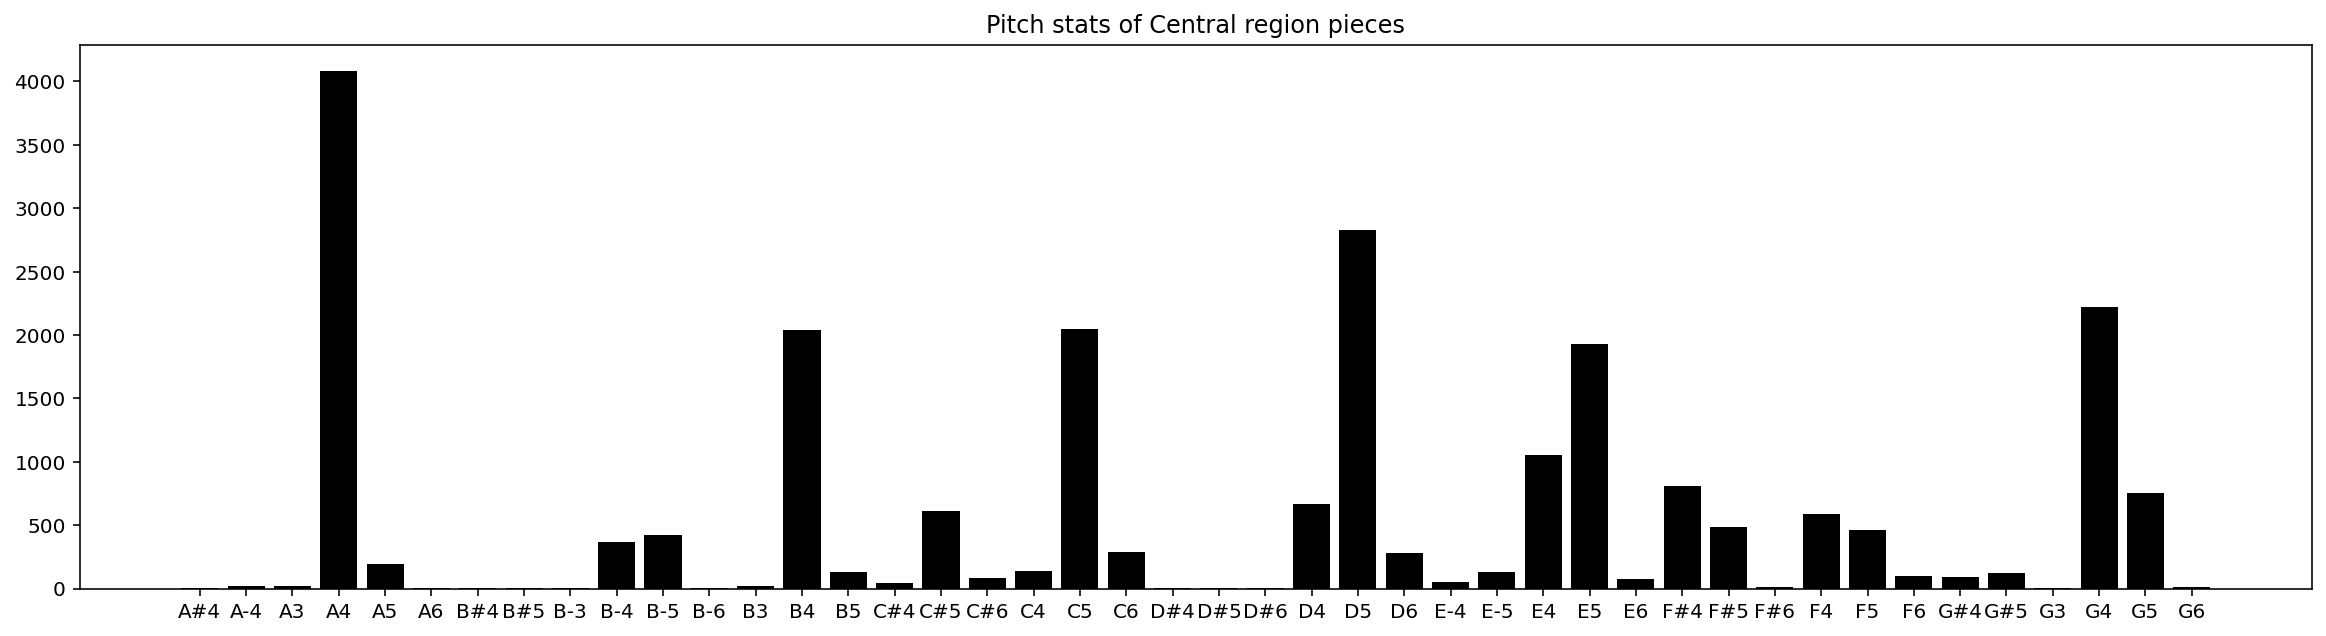

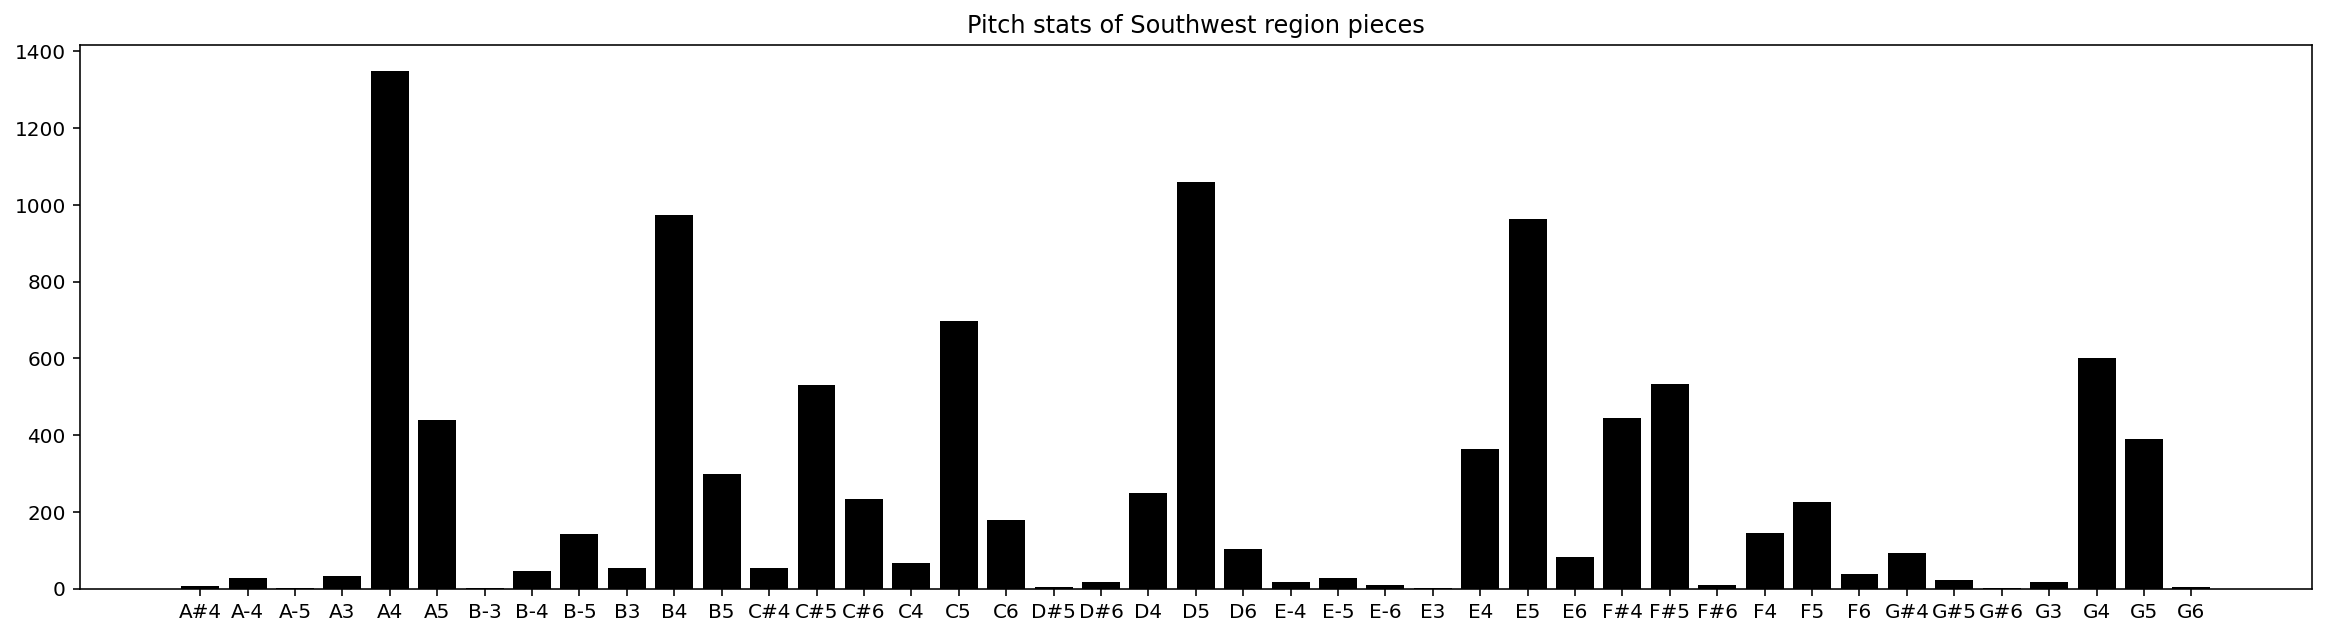

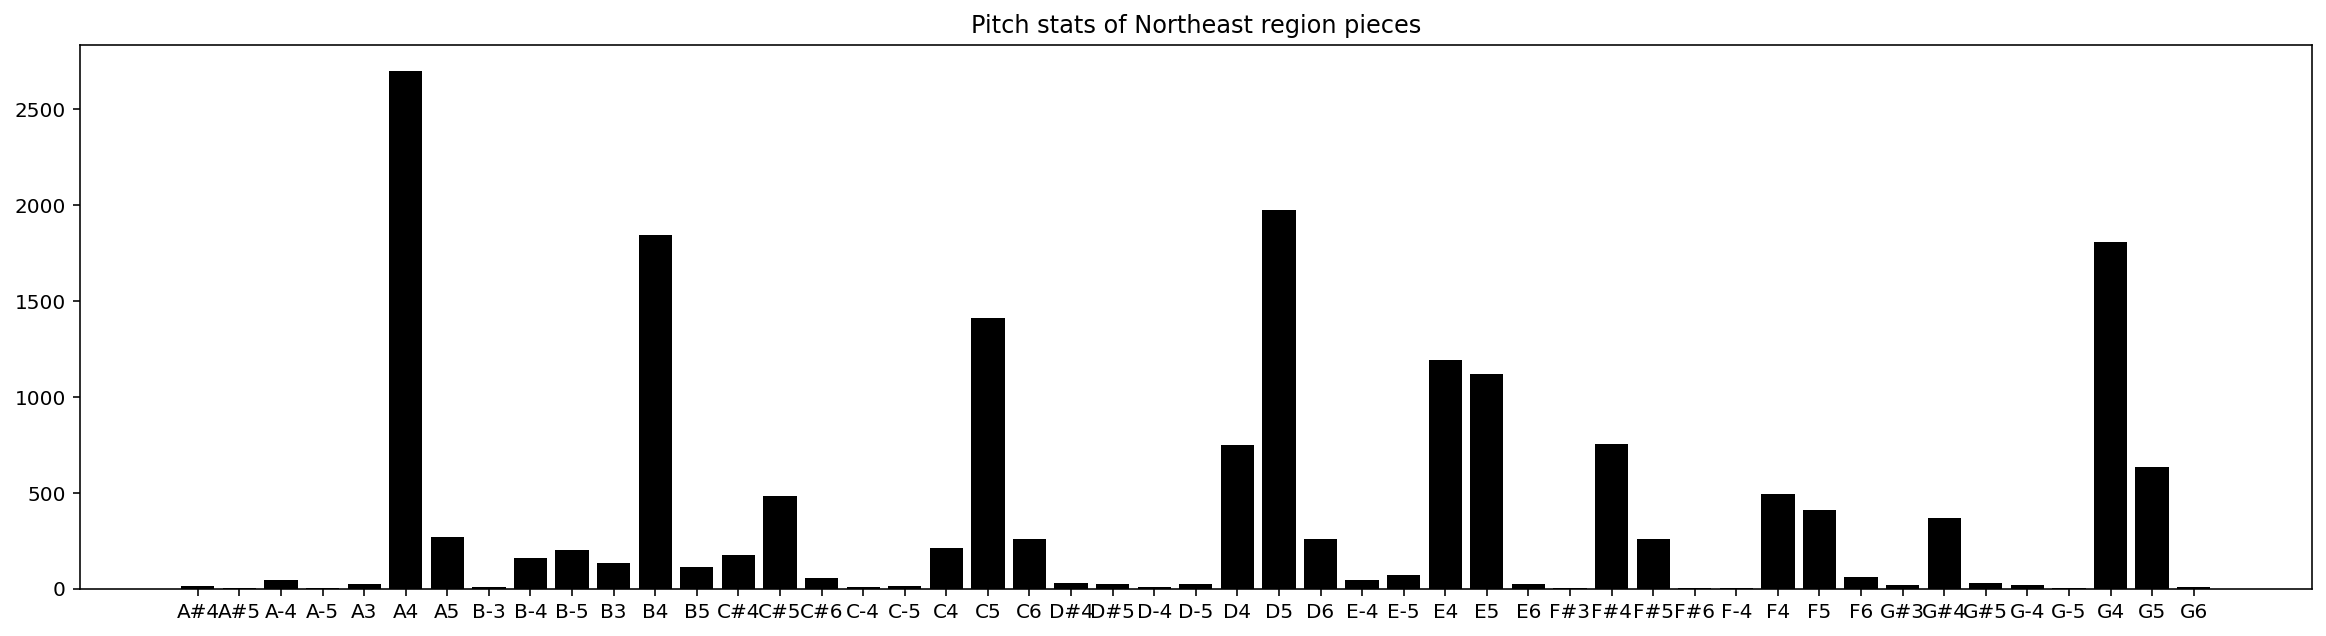

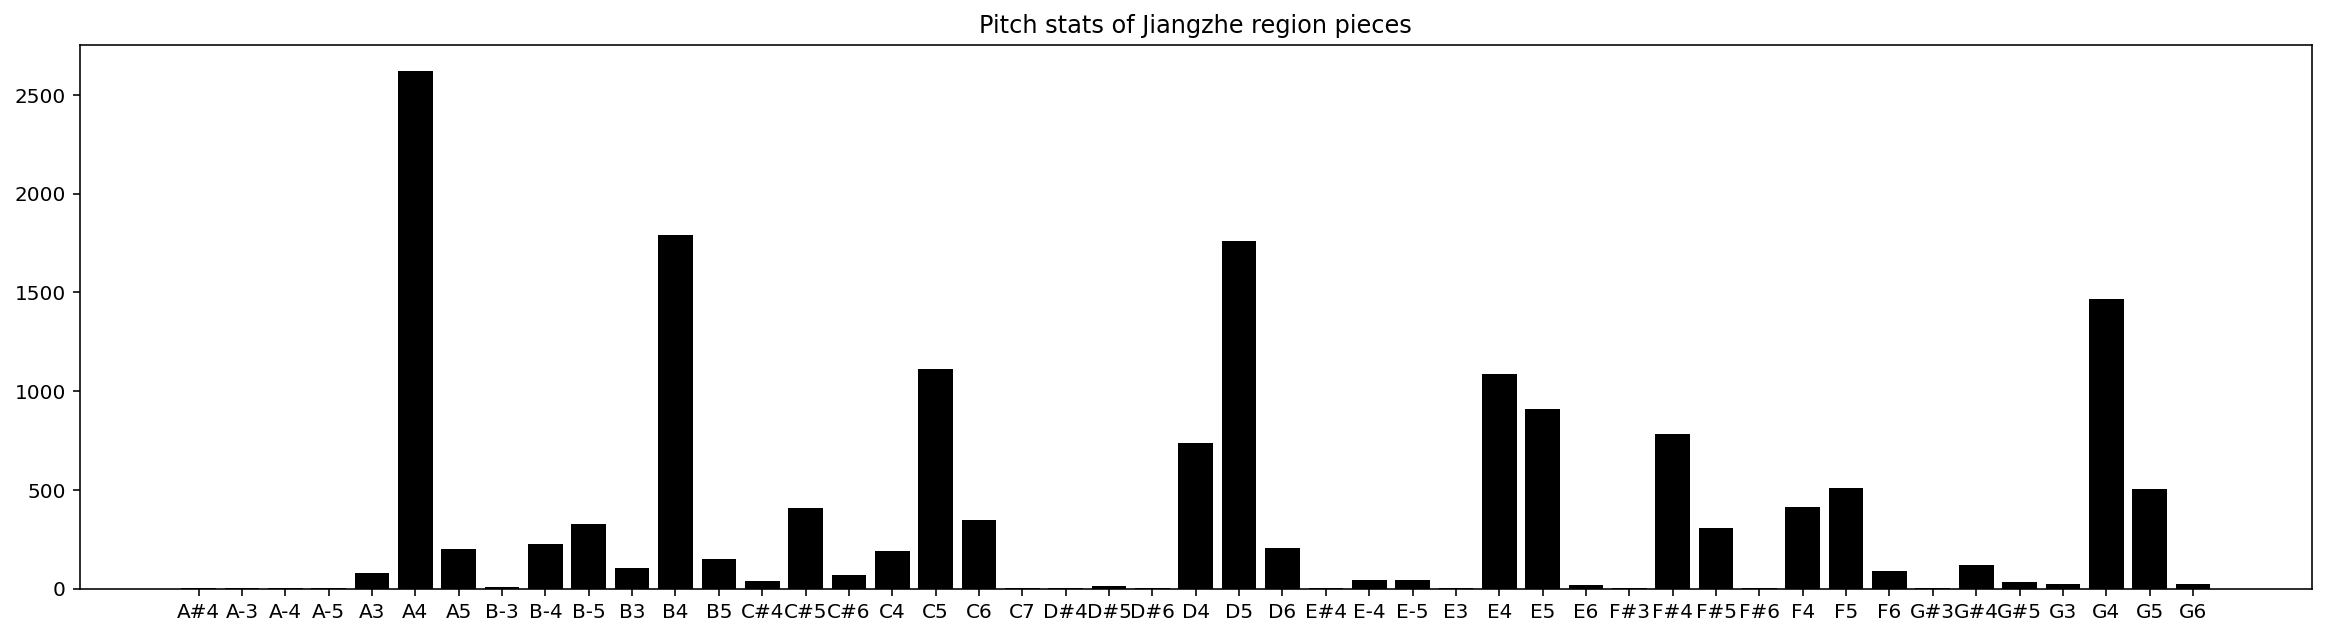

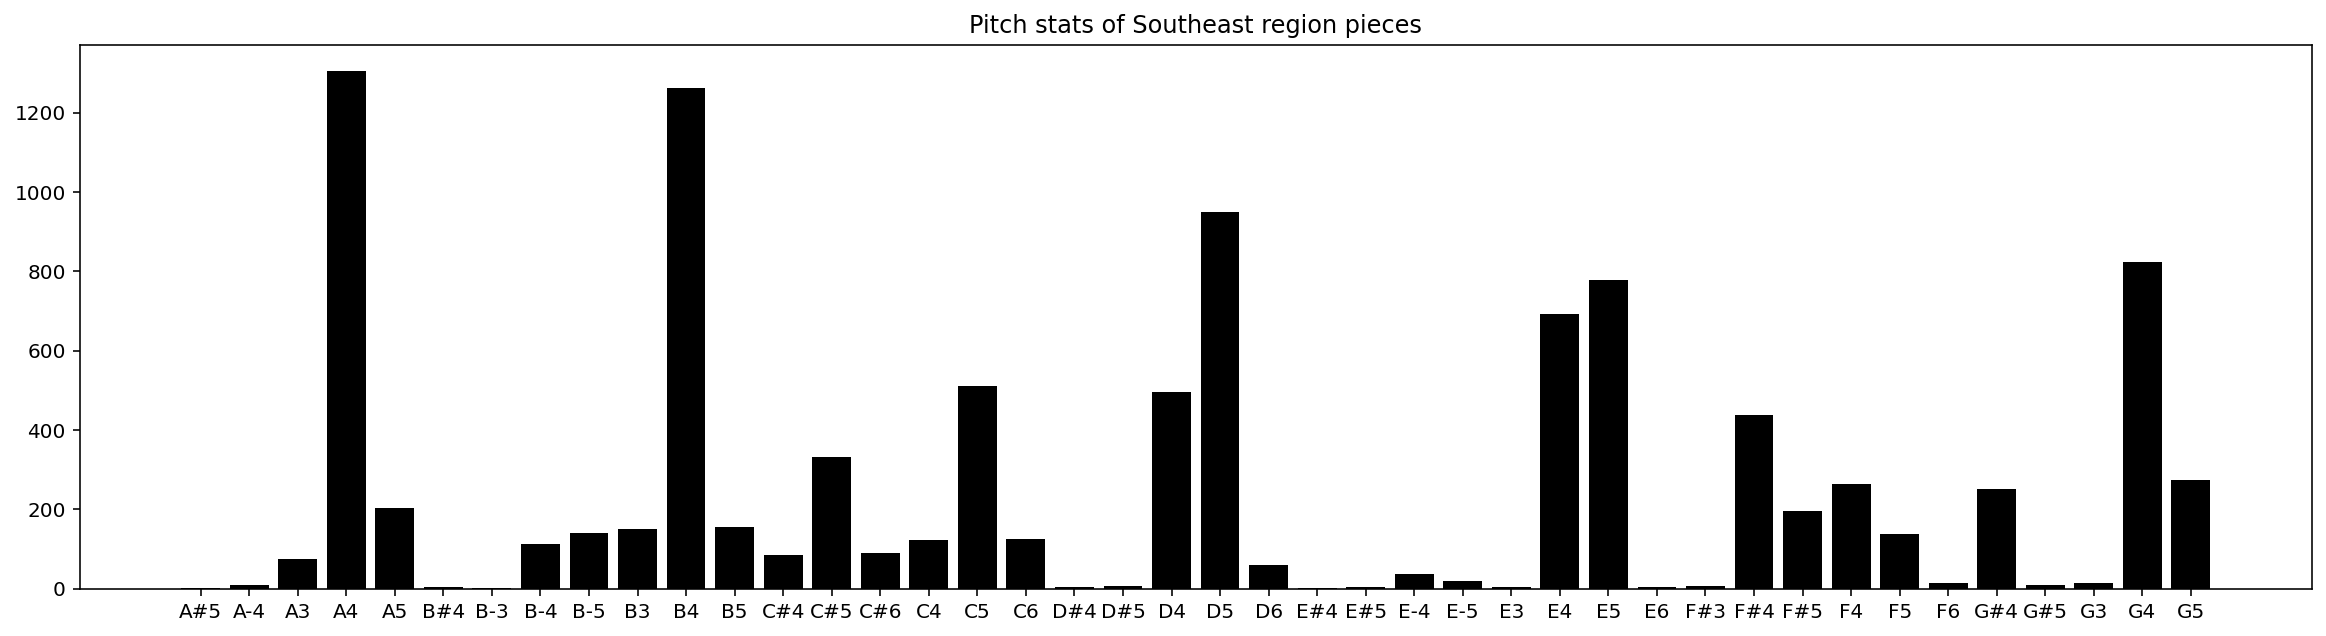

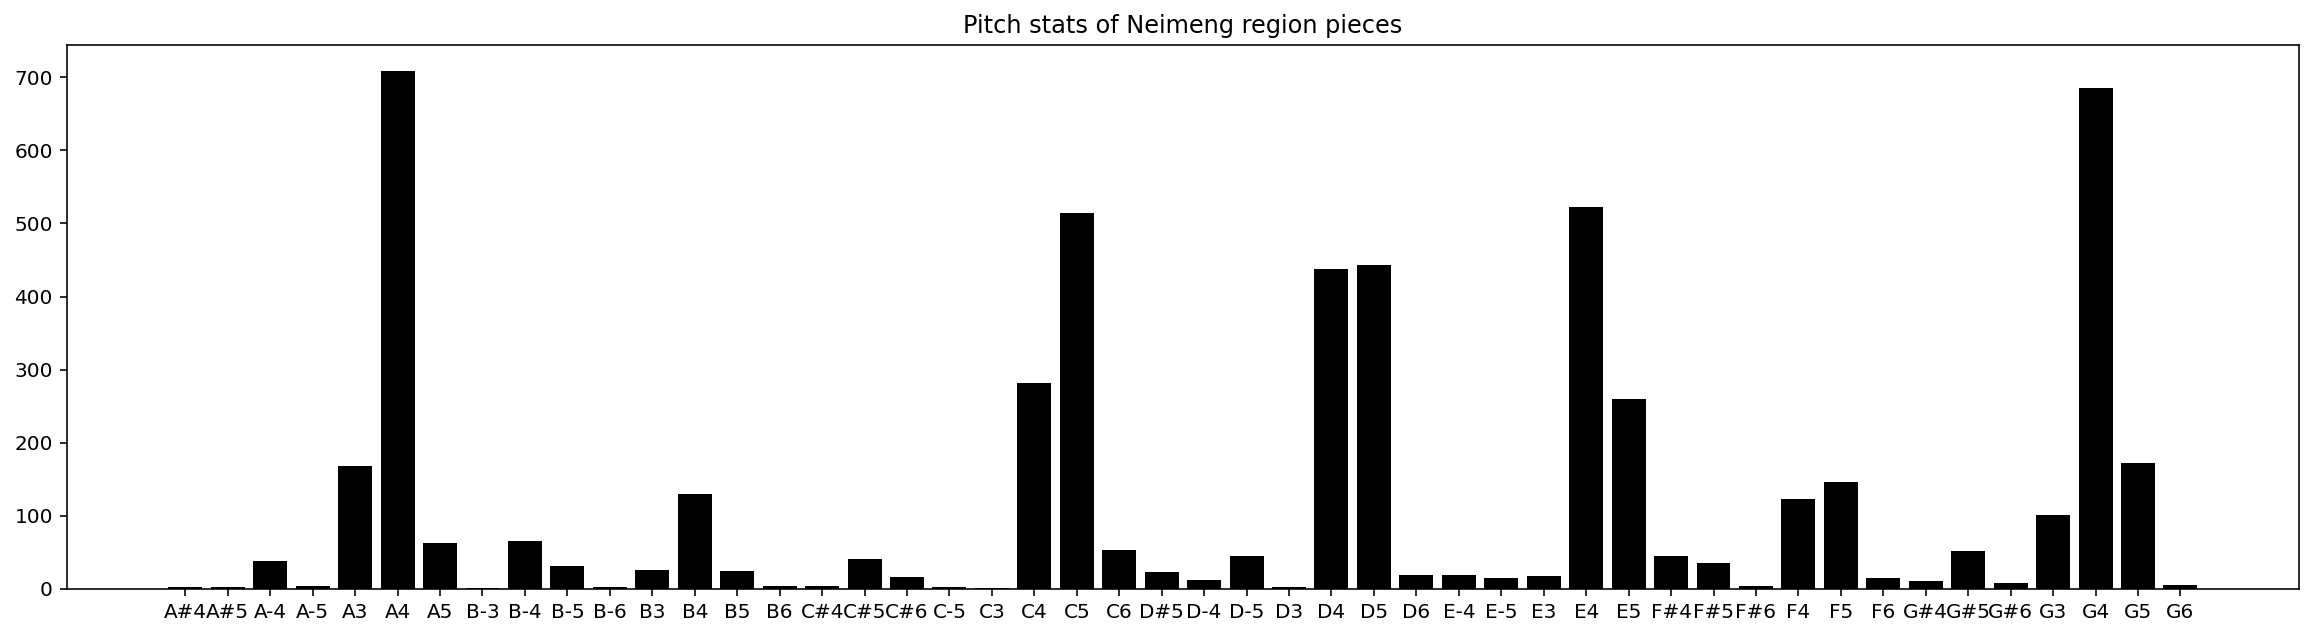

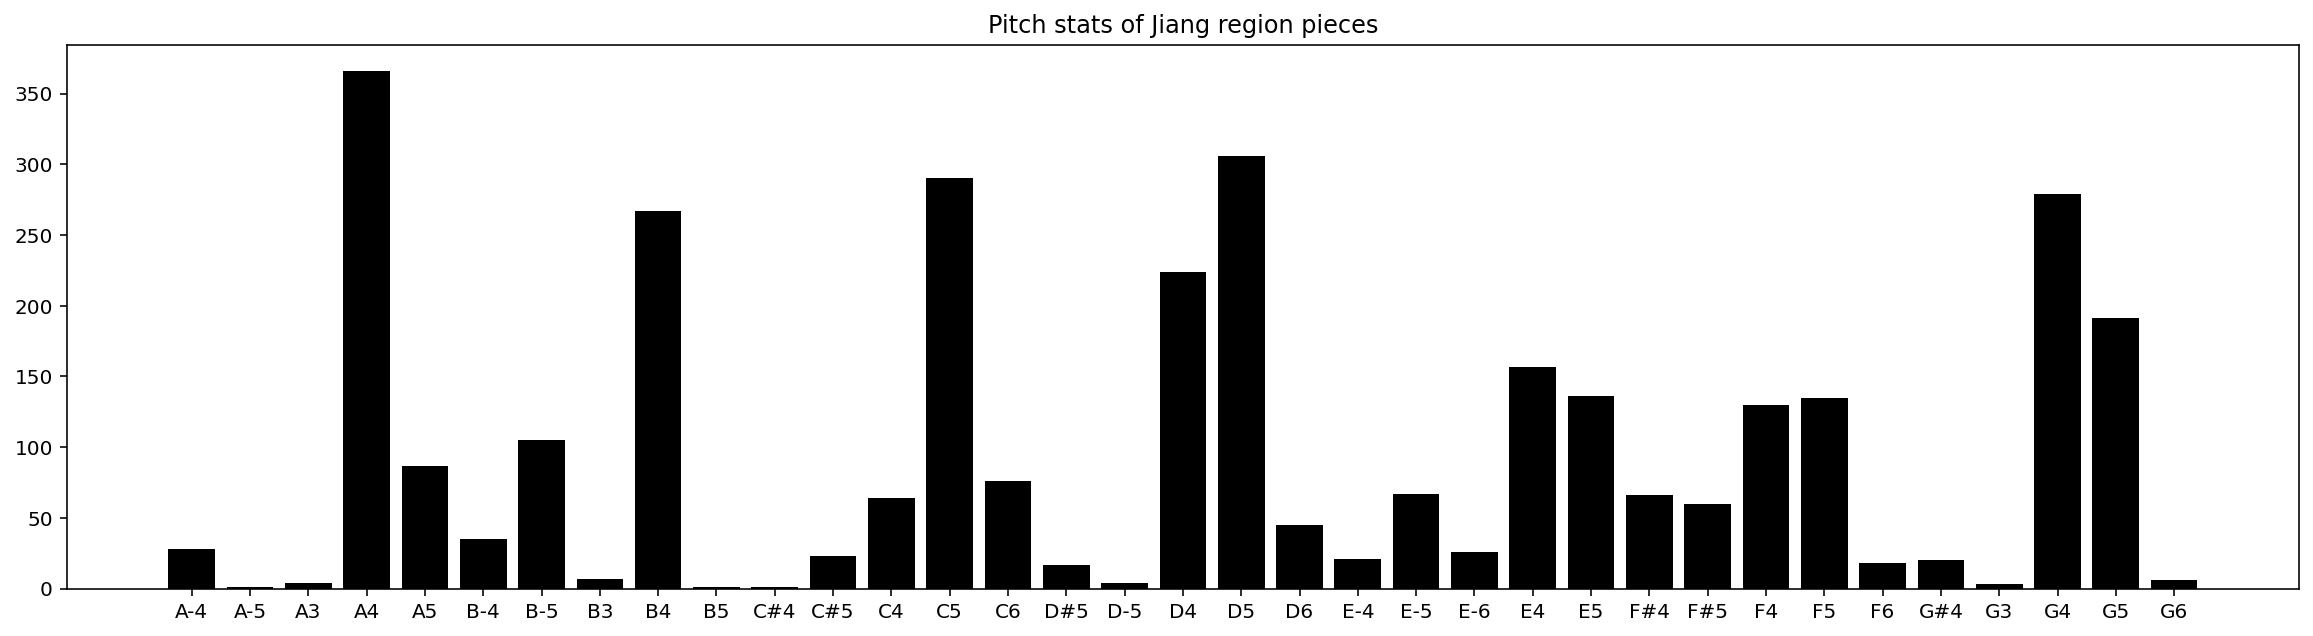

In [8]:
plt.rcParams["figure.figsize"] = (20,5)

region_pitch_counts = {}
for gloc in region_pitch_stat:
    
    counter = Counter(region_pitch_stat[gloc])
#     pitch_fractions = {i:counter[i] / len(region_pitch_stat[gloc]) for i in counter}
    pitch_fractions = {i:counter[i] for i in counter}
    region_pitch_counts[gloc] = sorted(pitch_fractions.items(), key=lambda pair: pair[0])
    
    x, y = zip(*region_pitch_counts[gloc])
    
    plt.bar(x, y, color='black')
    plt.title("Pitch stats of {} region pieces".format(gloc))
    plt.show()

By comparing each of these plots, we can get a first comparison of the pieces of each region. The first striking observation is that these distributions look similar across the regions. Indeed, we notice that A4, B4, C5, D5, and G4 are dominant in most regions. However, we can also observe differences. For instance, B4 is barely used in the Neimeng region compared to all the other ones.

These remarks give some first insight to our hypothesis: on average, there is no striking difference in the use of pitches across different regions of China. However, further analysis is required to determine the implications of the fluctuations.

### Scale Degree statistics (without metrical information)
In the previous subsection, we compared the use of pitches across regions. As an additional comparison, we now plot the distribution of scale degrees across regions.

For this visualization, we decided to sort the pitch classes by occurrences rather than alphabetically.

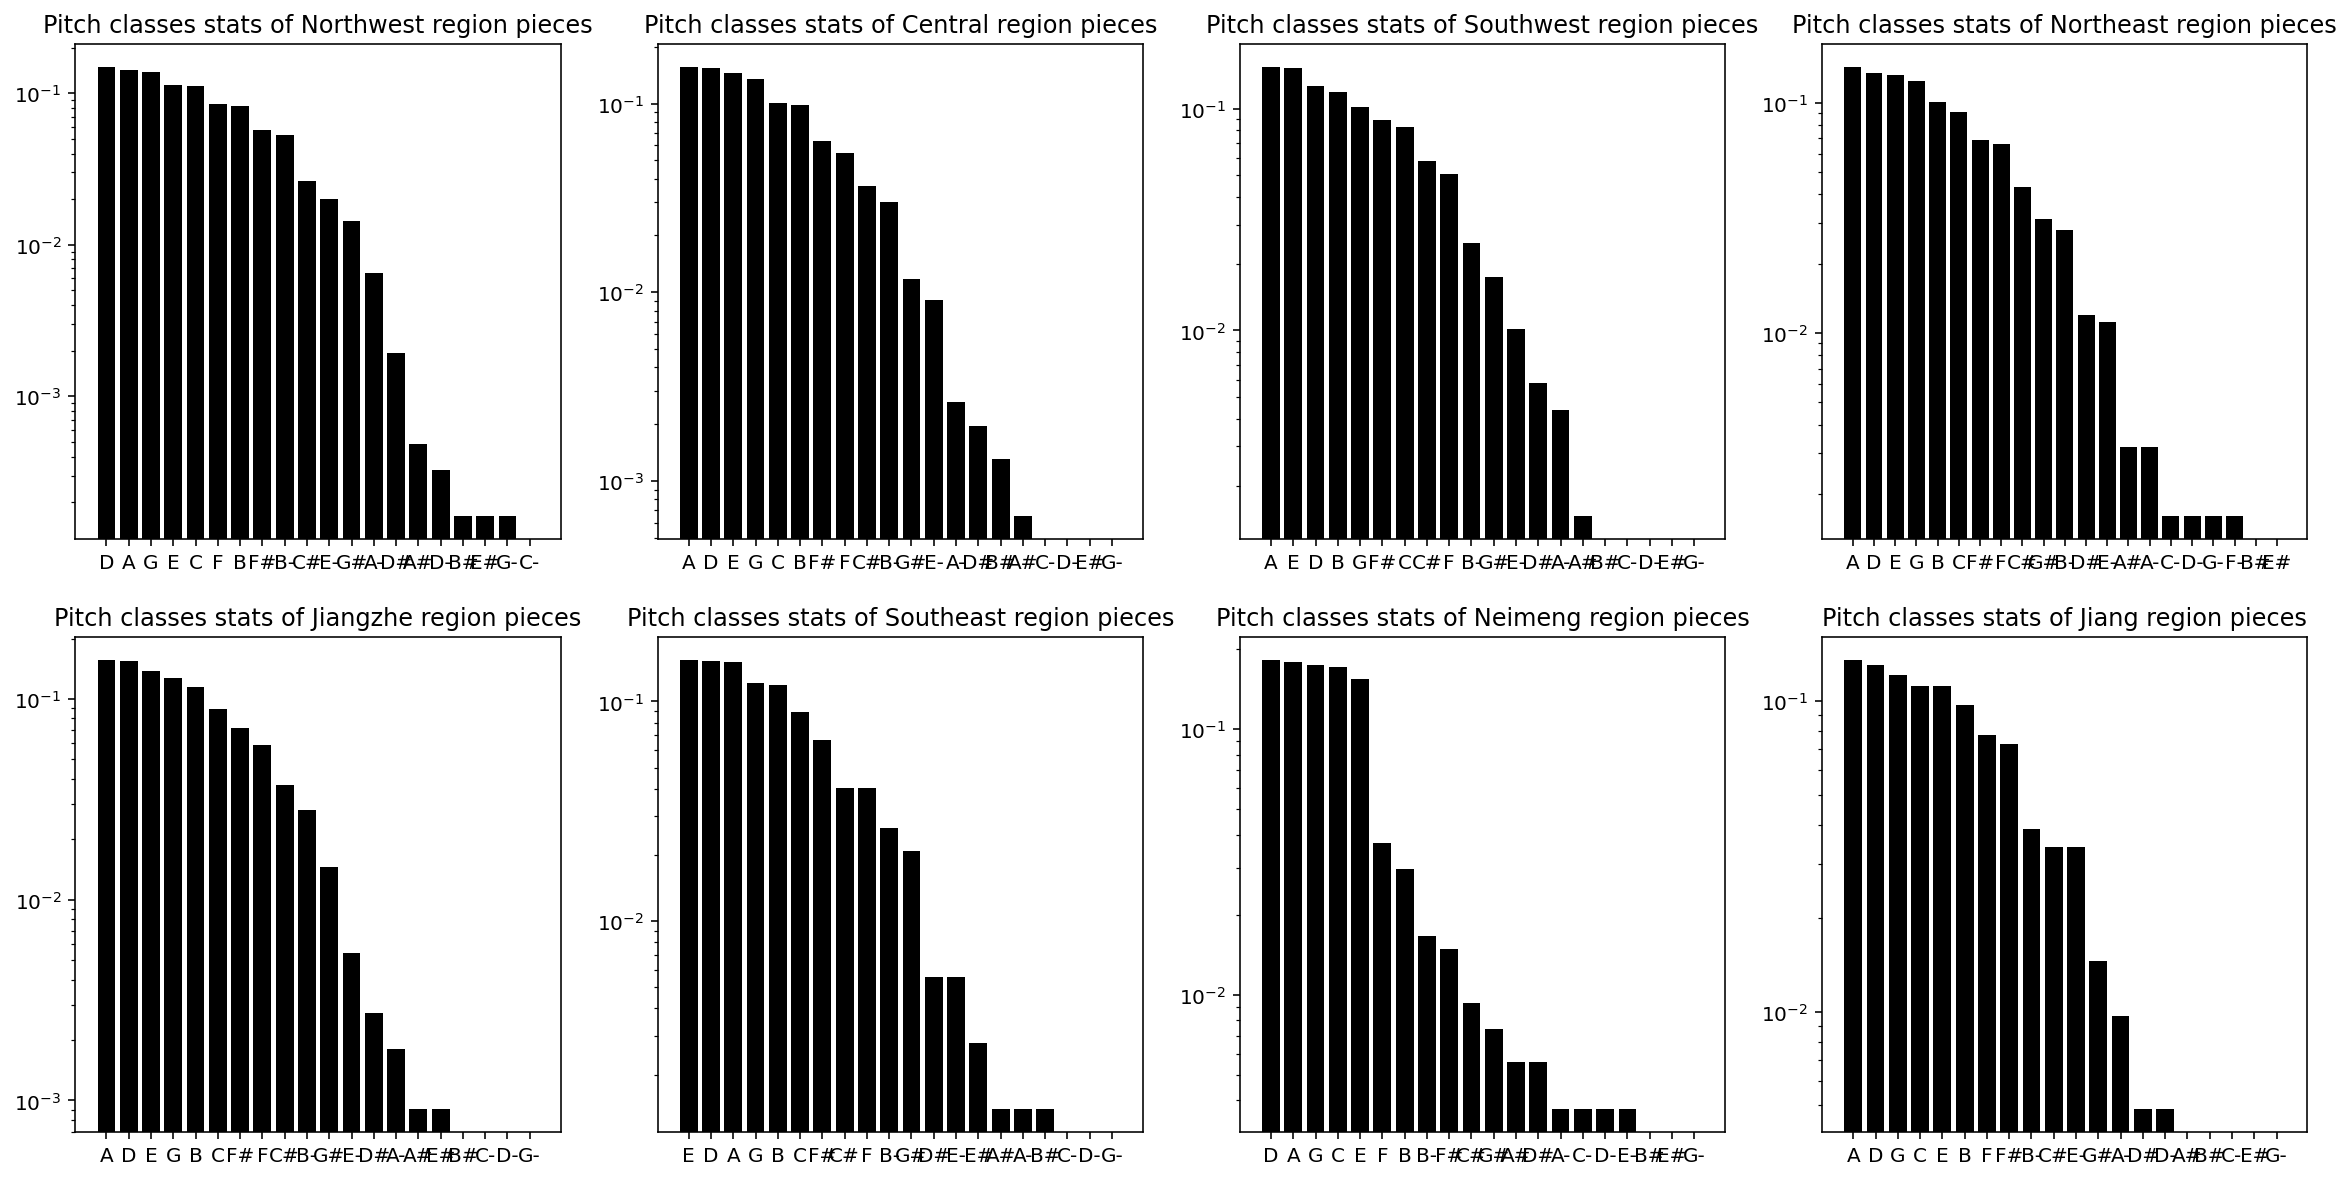

In [9]:
plt.rcParams["figure.figsize"] = (20,10)
region_scaledegree_counts = {}
fig, axarr = plt.subplots(2,4)

for gloc,ax in zip(region_scaledegree_stat, axarr.flat):
    
    counter = Counter(region_scaledegree_stat[gloc])
    scaledegree_fractions = {i:counter[i] / len(region_scaledegree_stat[gloc]) for i in counter}
#     scaledegree_fractions = {i:counter[i] for i in counter}
    scaledegree_fractions = {**scaledegree_defcount, **scaledegree_fractions}
    region_scaledegree_counts[gloc] = sorted(scaledegree_fractions.items(), key=lambda pair: -pair[1])
    x, y = zip(*region_scaledegree_counts[gloc])
    ax.bar(x, y, color='black')
    ax.set_yscale('log')
    ax.set_title("Pitch classes stats of {} region pieces".format(gloc))

A visual comparison of these plots again reveals a great similarity between all regions as `A`, `D` and `E` most often closely compete for the three most used pitch classes. However, we notice once again a significant difference in the Neimeng region, where there is a drop after the 5 most used pitch classes.

These results once again go against our hypothesis. However, the singular example of the Neimeng region must be remembered for the rest of the analysis.

A visual comparison of these plots again reveals a great similarity between all regions as `A`, `D` and `E` most often closely compete for the three most used pitch classes. However, we notice once again a significant difference in the Neimeng region, where there is a drop after the 5 most used pitch classes.

These results once again go against our hypothesis. However, the singular example of the Neimeng region must be remembered for the rest of the analysis.

### Scale degrees statistics after transposig to C (without metrical information)
In our research questions, we were particularly interested in the organization of the piece around the central pitch. For that reason, we transposed all pieces to C relatively to their tonic. Analyzing the pitches of these transposed scores reveals information about the use of scale degrees.

As a first analysis, we plot the distribution of use of scale degrees by simply counting them. Note that for simplicity, instead of labeling the plots with scale degrees, they are simply labeled with their pitch class relative to C. Therefore G is V, D is II, etc...

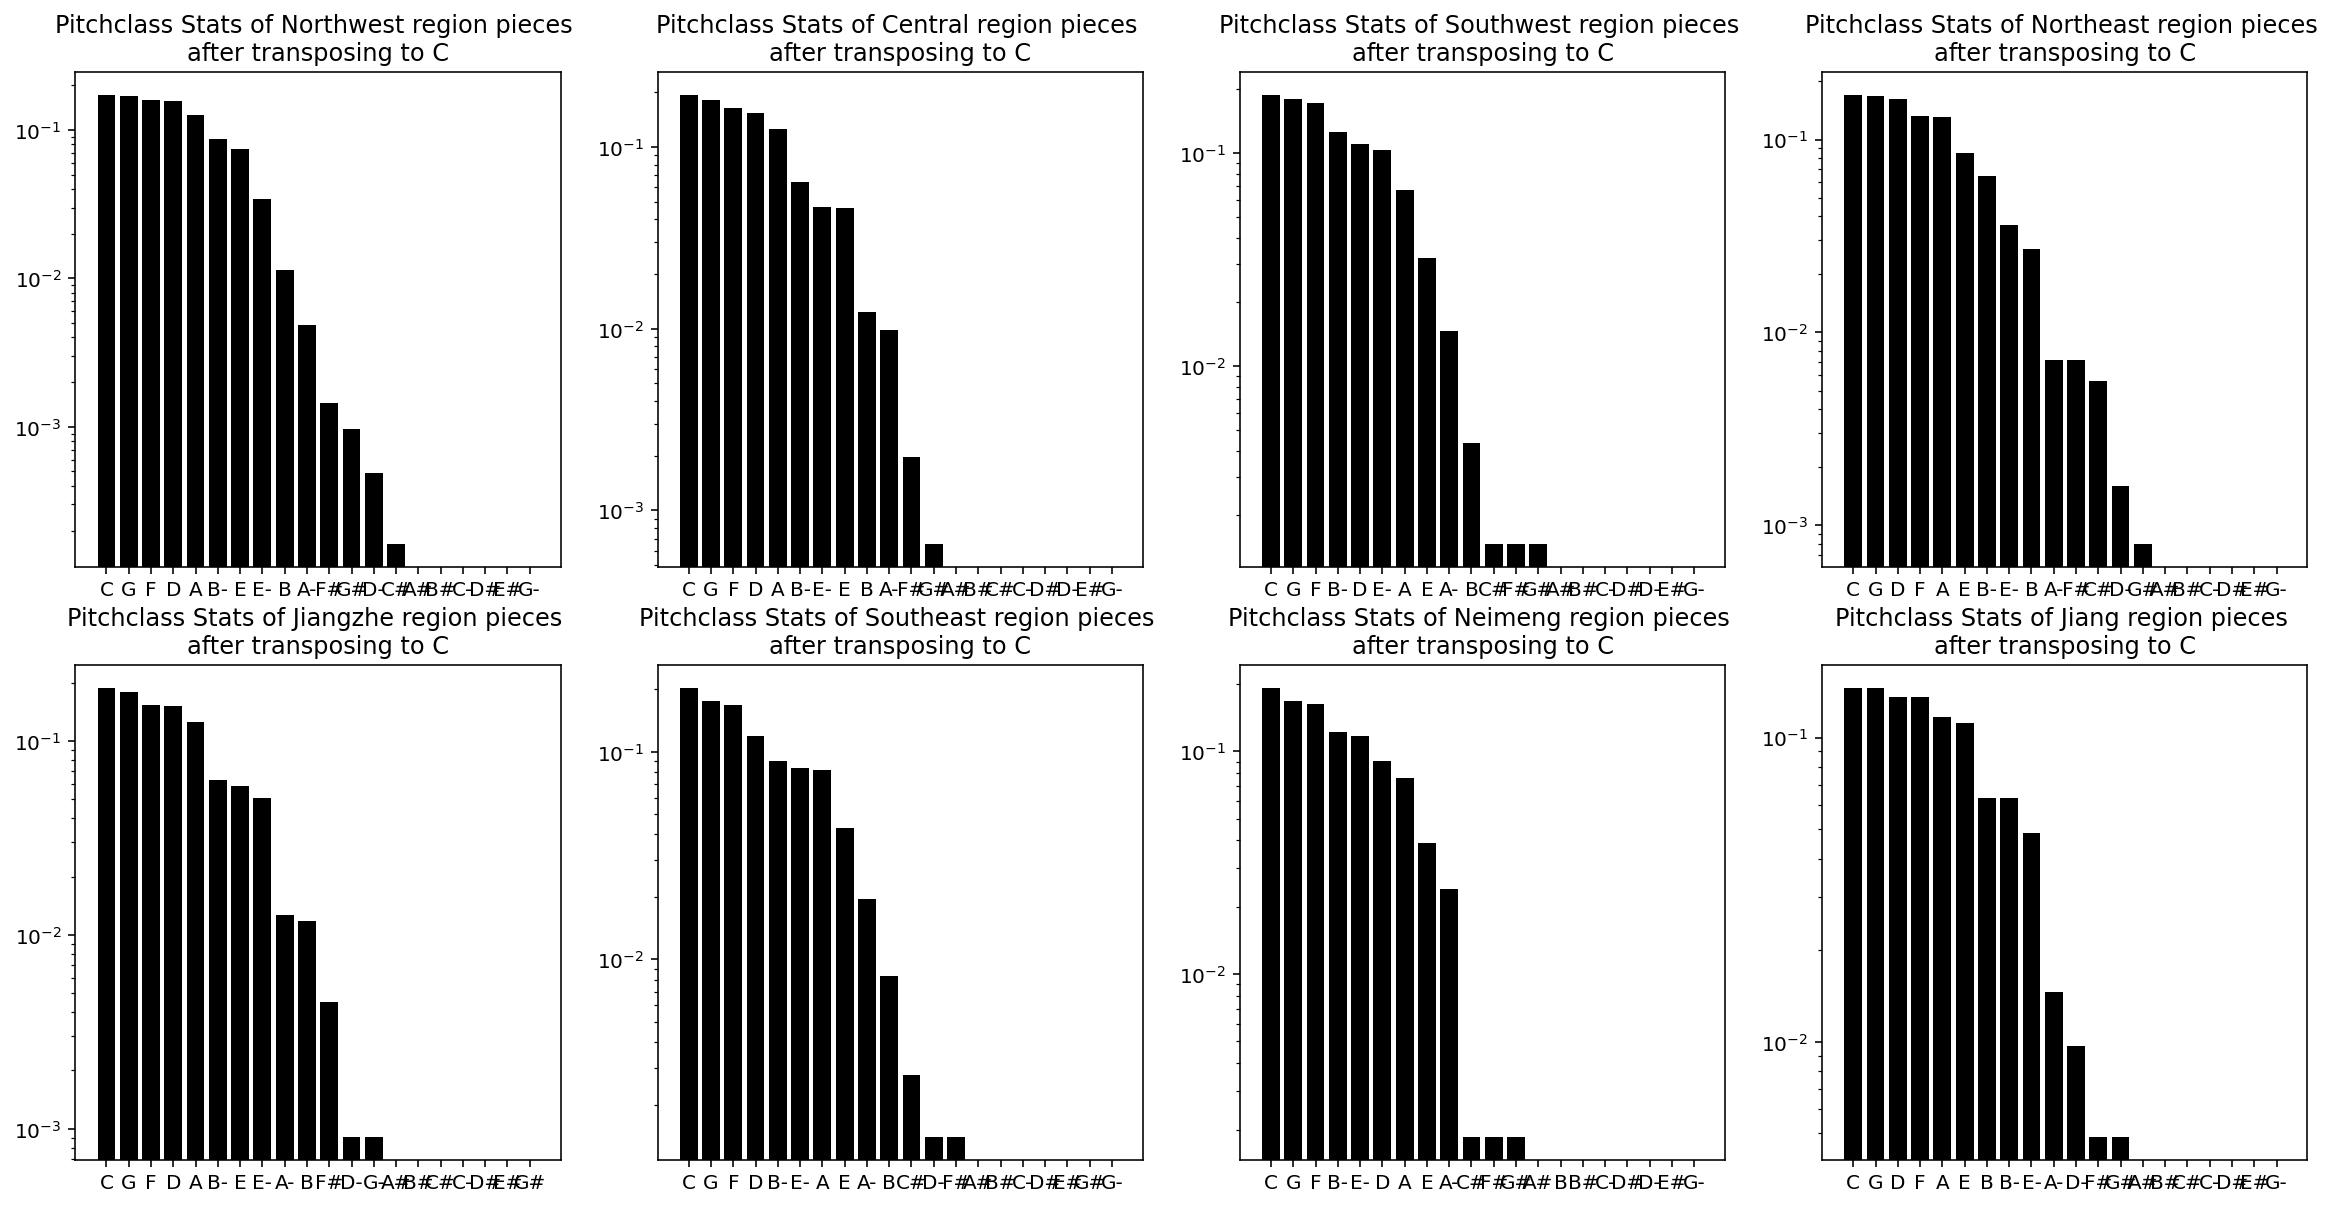

In [10]:
plt.rcParams["figure.figsize"] = (20, 10)
fig, axarr = plt.subplots(2,4)

region_scaledegree_transposed_counts = {}

for gloc, ax in zip(region_scaledegree_transposed_stat, axarr.flat):
    
    counter = Counter(region_scaledegree_transposed_stat[gloc])
    scaledegree_transposed_fractions = {i:counter[i] / len(region_scaledegree_transposed_stat[gloc]) for i in counter}
#     scaledegree_transposed_fractions = {i:counter[i] for i in counter}
    scaledegree_transposed_fractions = {**scaledegree_defcount, **scaledegree_transposed_fractions}
    region_scaledegree_transposed_counts[gloc] = sorted(scaledegree_transposed_fractions.items(), key=lambda pair: -pair[1])
    x, y = zip(*region_scaledegree_transposed_counts[gloc])
    ax.bar(x, y, color='black')
    ax.set_yscale('log')
    ax.set_title("Pitchclass Stats of {} region pieces \nafter transposing to C".format(gloc))

These plots reveal that the distributions of use of scale degrees across regions are vastly similar, thus once again refuting our initial hypothesis. However, it is interesting to note that like in Western music, the fifth and fourth are the most dominant scale degrees.

### Pitch Classes Transitions (without metrical information)

Another means to compare the organization of songs of different divisions is to look at the transitions between the pitches. Comparing these transitions will reveal whether the folks preferred certain pitch transitions to others and may show significant differences across regions.

For this purpose, we create a dictionary to store the count of transitions of the pitch classes in all pieces belonging to one division. The name of the division is the key of the mentioned dictionary and the value is a nested dictionary with keys as the starting pitch class and the values as dictionaries with key as the transitioned pitch class and value as the count of such occurrence.

In [11]:
pitchclass_transition = {geo_region: {} for geo_region in geo_divisions}
interval_transition = {geo_region: {} for geo_region in geo_divisions}

for gloc in tqdm(music_data):
    
    for score in music_data[gloc]["scores"]:
        score_title = score.metadata.title
        region = CFS_full[CFS_full["title"] == score_title].geo_division.values[0]
        tonic = CFS_full.loc[CFS_full["title"] == score_title, 'tonic'].iloc[0]
        if (region != "Null") and not (tonic != tonic):
            
            # transposing
            i = interval.Interval(pitch.Pitch(tonic), pitch.Pitch("C")).semitones
            transposed_score = score.transpose(i)
            
            prev = None
            prev_pitch = None
            for part in transposed_score.parts:
                for measure in part:
                    if type(measure) is not stream.Measure:
                        continue
                    for note_ in measure:
                        if type(note_) is not note.Note:
                            continue
                        if prev != None:
                            if prev not in pitchclass_transition[region]:
                                pitchclass_transition[region][prev] = {}
                            if note_.name not in  pitchclass_transition[region][prev]:
                                pitchclass_transition[region][prev][note_.name] = 1
                            else:
                                pitchclass_transition[region][prev][note_.name] += 1
                        if prev_pitch != None:        
                            interval_name = interval.Interval(prev_pitch, note_.pitch).simpleName
                            if interval_name not in interval_transition[region]:
                                interval_transition[region][interval_name] = 1
                            else:
                                interval_transition[region][interval_name] += 1
                                
                        prev = note_.name
                        prev_pitch = note_.pitch  

100%|██████████| 4/4 [01:11<00:00, 17.76s/it]


Now using the pitch class transitions in each division we create a network with pitch class as the nodes and creating an edge in case there is a transition between the nodes. The graph will be directed meaning there exists an edge only in the direction where the pitch transition occurs.

We plot the transitions as heatmaps to help in the interpretation. To create them, we first convert the transition counts from a dictionary to a `DataFrame` and use it to plot the heatmap.

In [12]:
def sort_dict(item):
    # function to sort a nested dictionary based on key
    # credits: https://gist.github.com/gyli/f60f0374defc383aa098d44cfbd318eb
    return {k: sort_dict(v) if isinstance(v, dict) else v for k, v in sorted(item.items())}

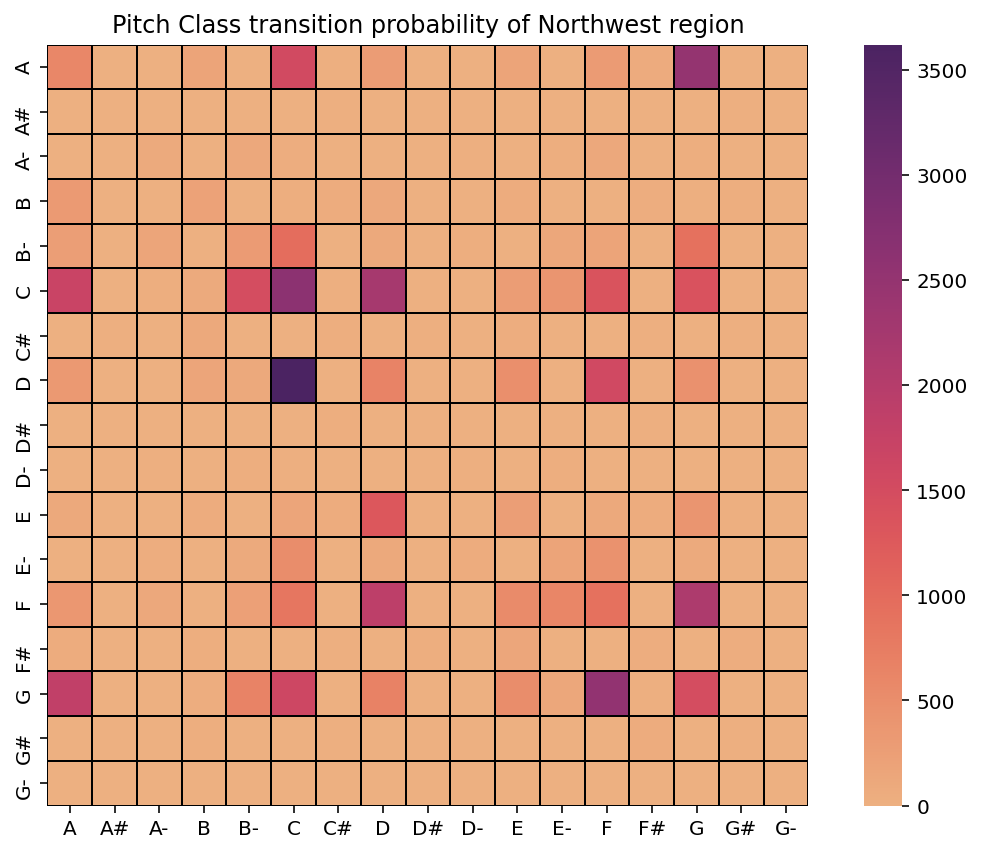

----------------------------------------------------------------------------------------------------


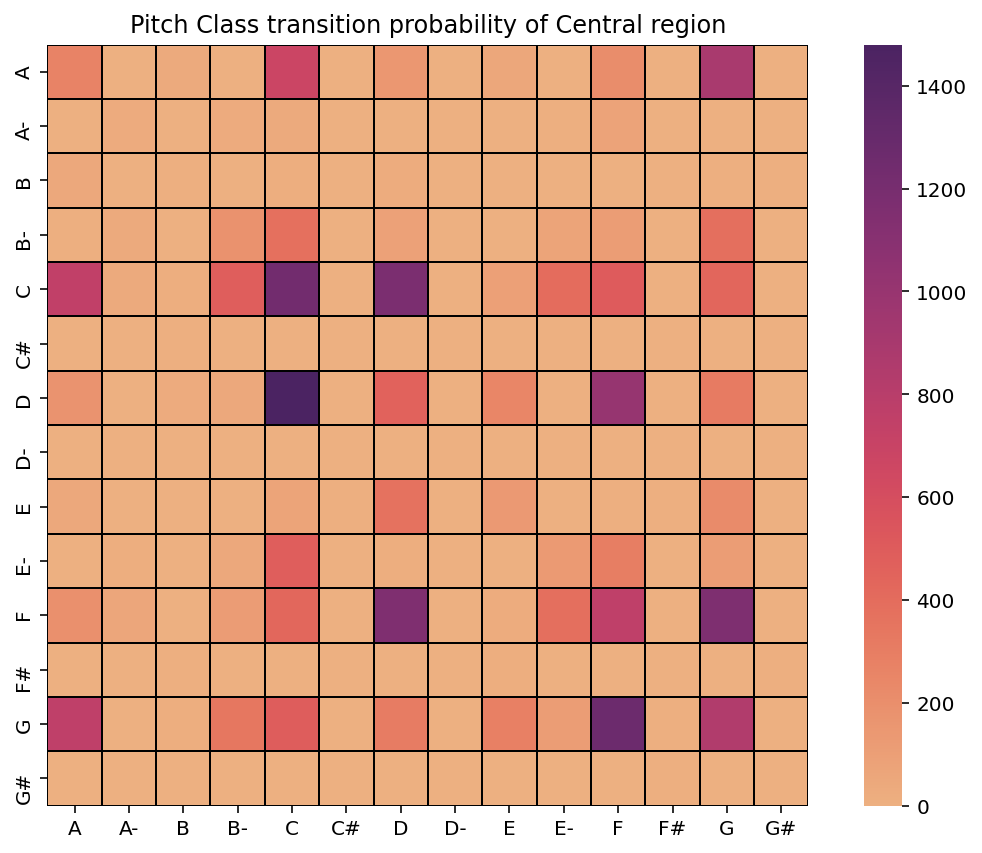

----------------------------------------------------------------------------------------------------


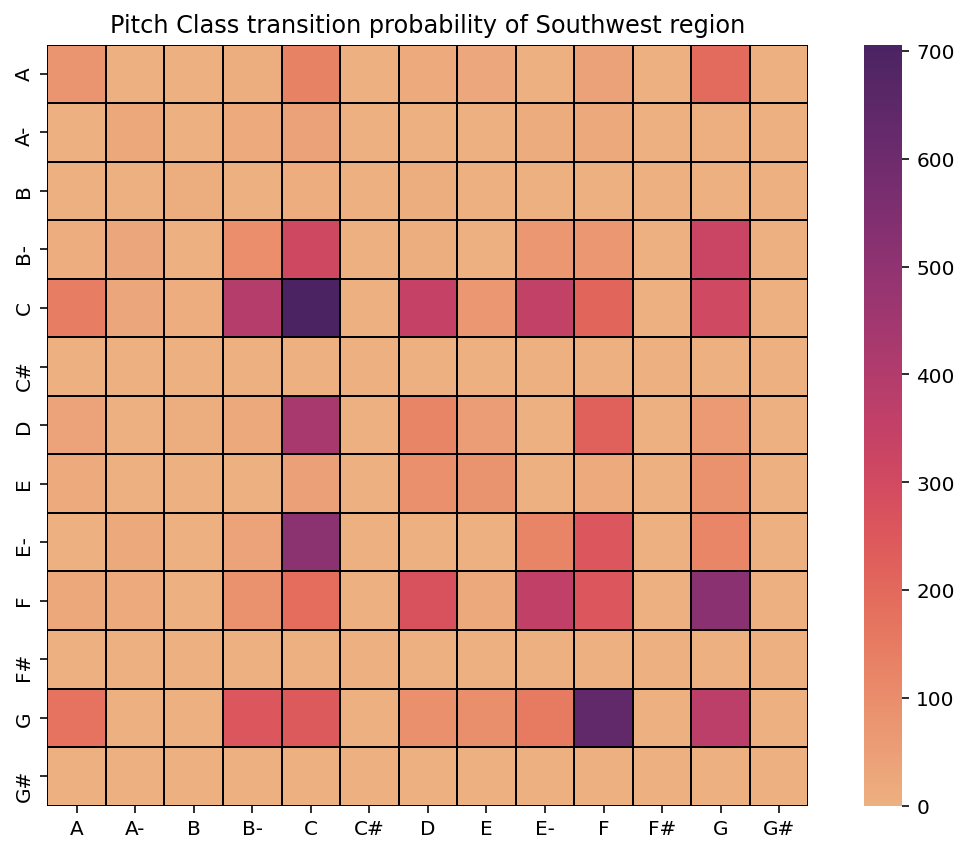

----------------------------------------------------------------------------------------------------


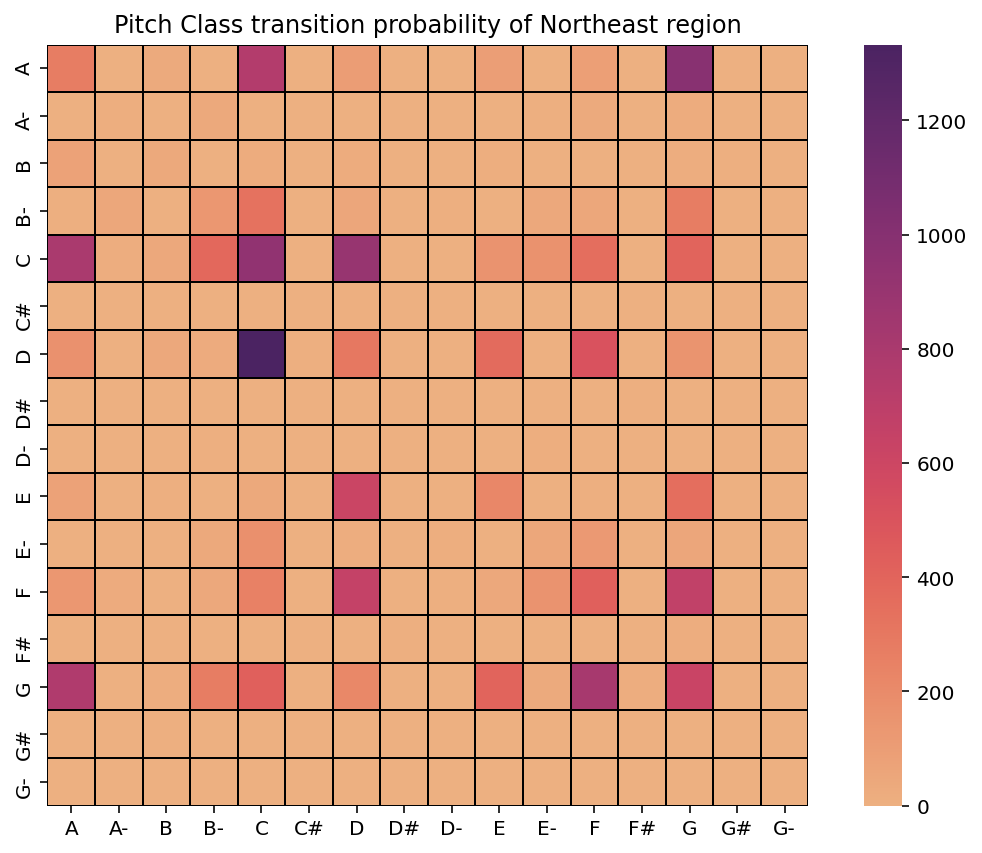

----------------------------------------------------------------------------------------------------


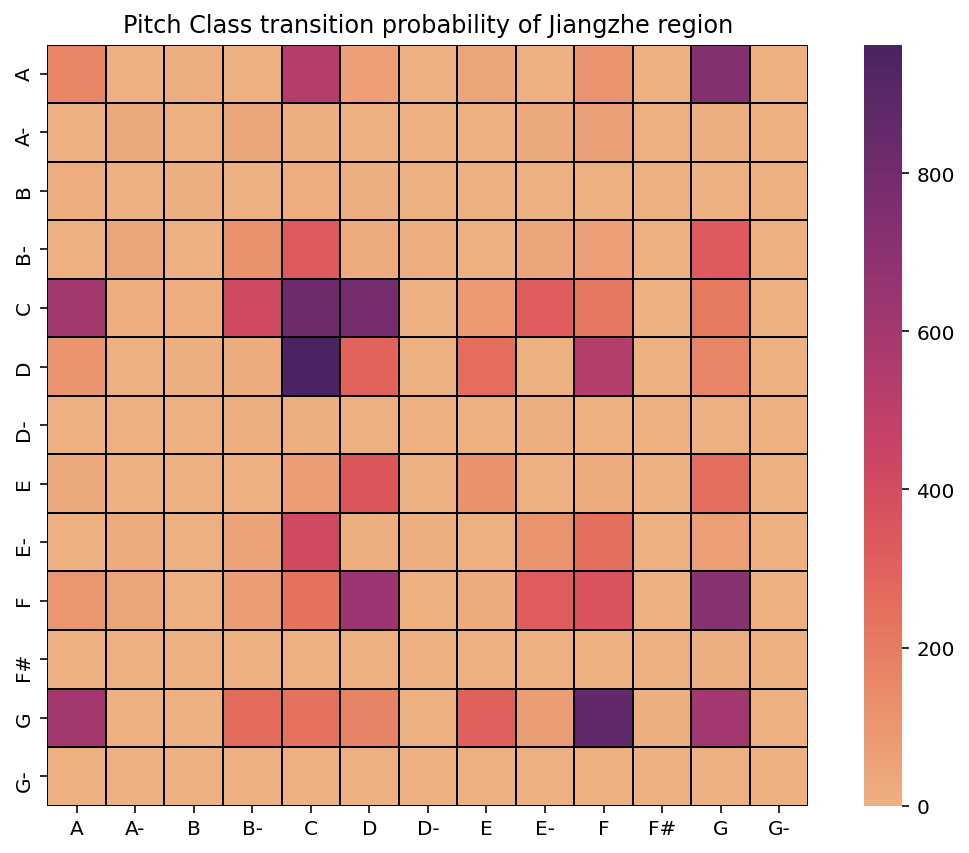

----------------------------------------------------------------------------------------------------


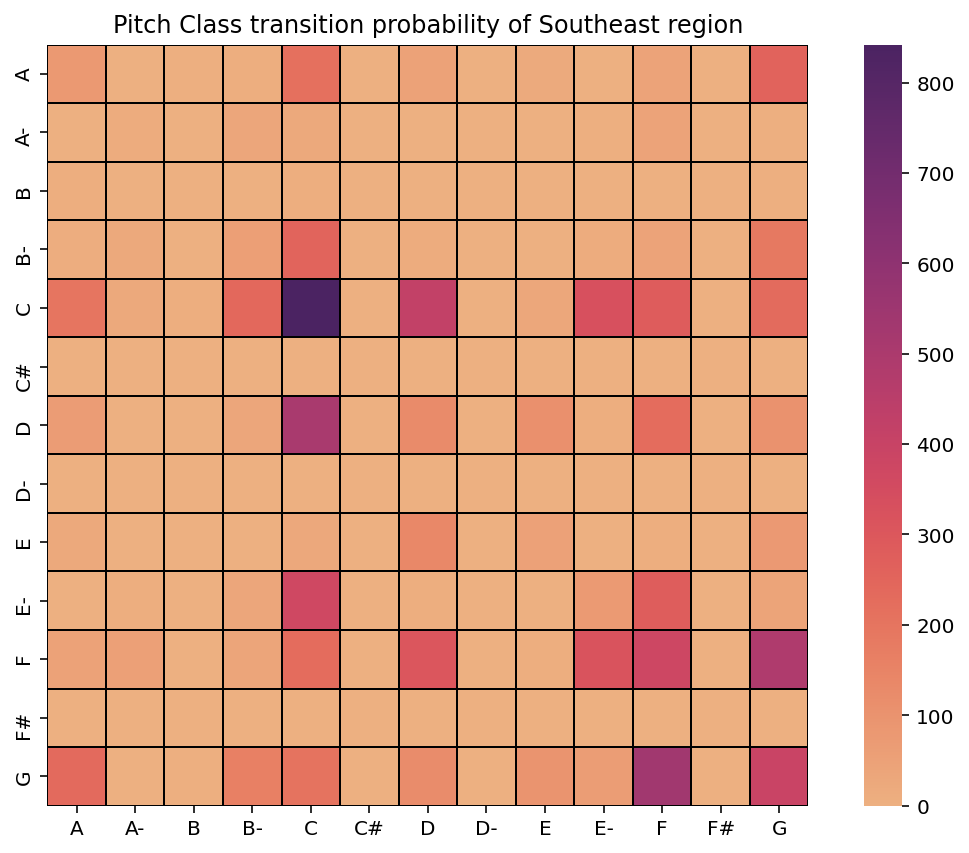

----------------------------------------------------------------------------------------------------


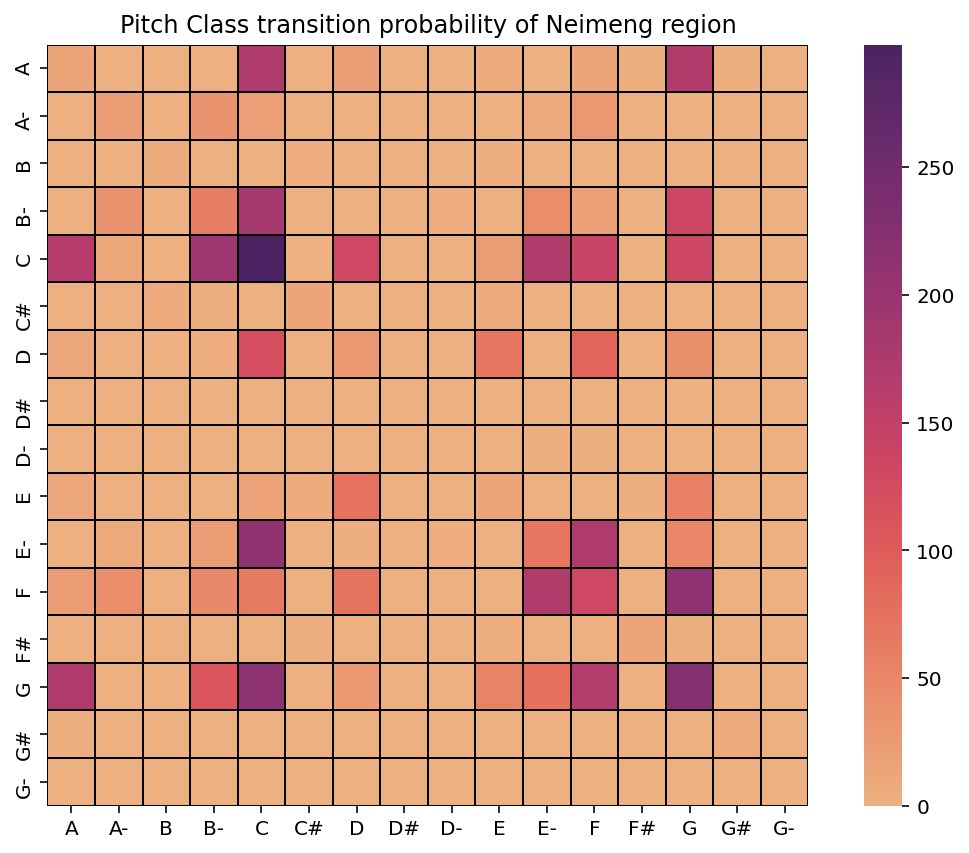

----------------------------------------------------------------------------------------------------


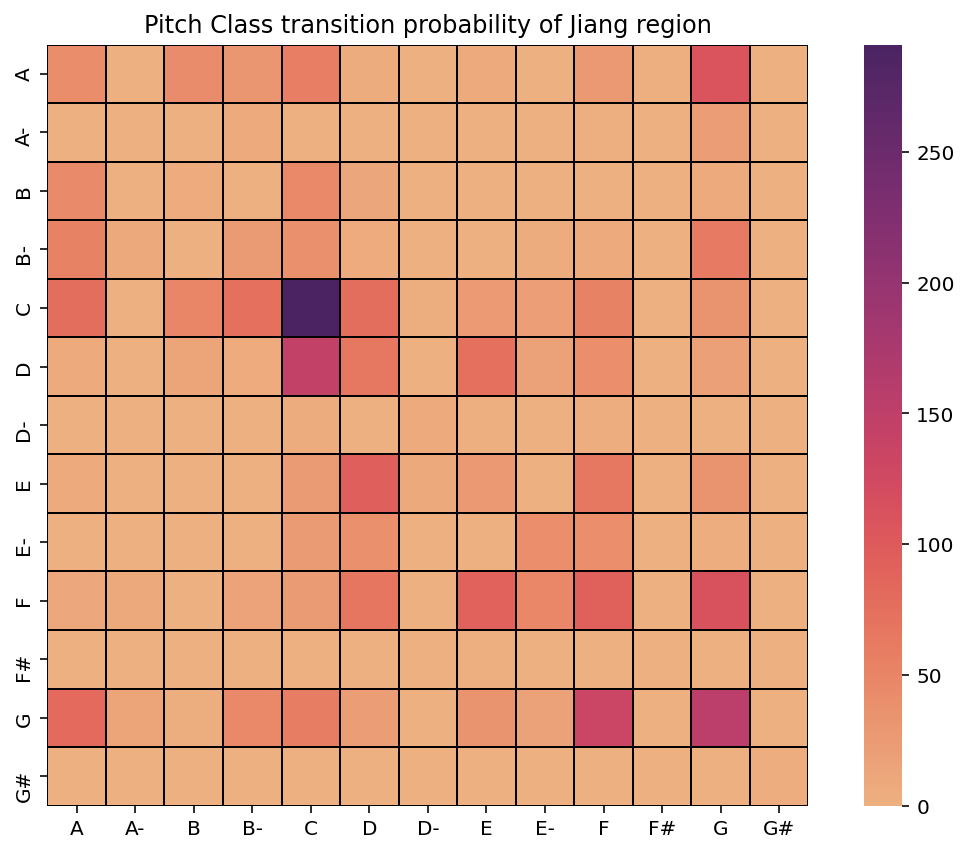

----------------------------------------------------------------------------------------------------


In [13]:
plt.rcParams["figure.figsize"] = (10, 7)
colormap = sns.color_palette("flare", as_cmap=True)
for gloc in geo_divisions:
    fig, axes = plt.subplots(1,1)
    
    sorted_probs = sort_dict(pitchclass_transition[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax1 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    axes = ax1
    ax1.set_title("Pitch Class transition probability of {} region".format(gloc))
    plt.show()
    
    print("--"*50)

### Interval Transitions (without metrical information)

Another means to compare the organization of songs of different divisions is to look at the transitions between the intervals.

For this purpose, we create a dictionary to store the count of transitions of the intervals in all pieces belonging to one division. The name of the division is the key of the mentioned dictionary and the value is the count of such occurrence.

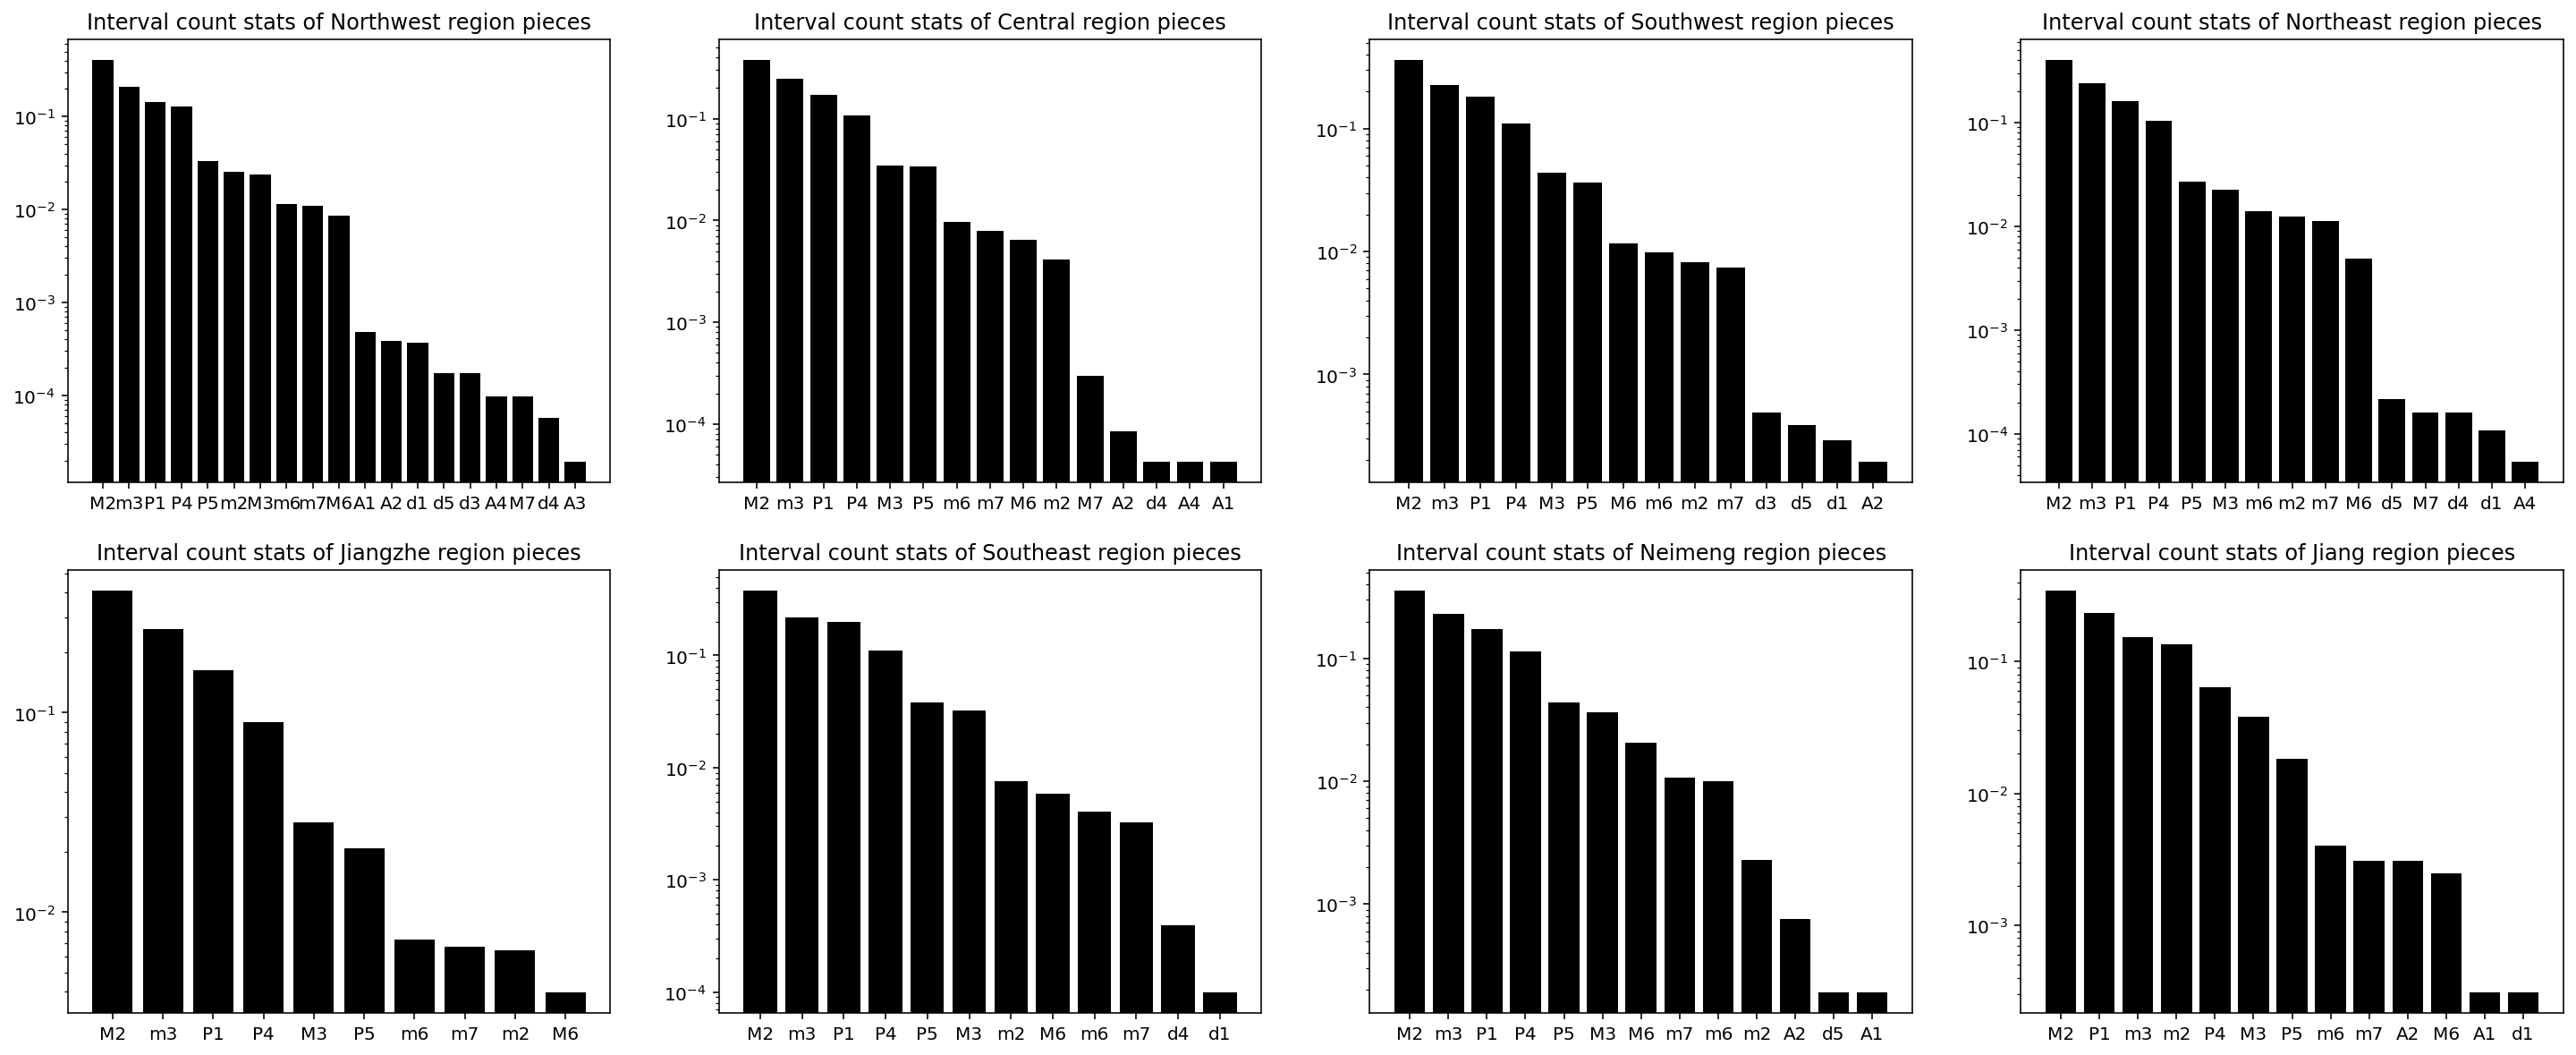

In [14]:
plt.rcParams["figure.figsize"] = (25, 10)
fig, axarr = plt.subplots(2,4)

for division_name, ax in zip(interval_transition, axarr.flat):
    division_intervals = interval_transition[division_name]
    # get values in the same order as keys
    total_interval_count = sum(division_intervals.values())
    interval_fractions = {i:division_intervals[i] / total_interval_count for i in division_intervals}
    sorted_interval_fractions = {k: v for k, v in sorted(interval_fractions.items(), key=lambda item:-item[1])}
    x = (sorted_interval_fractions.keys())
    y = (sorted_interval_fractions.values())
    ax.bar(x, y, color='black')
    ax.set_yscale('log')
    ax.set_title("Interval count stats of {} region pieces".format(division_name))

### Pitch statistics (with metrical information)

For now metrical information is the duration of the note

In [15]:
region_pitch_transposed_stat_met = {geo_region: {} for geo_region in geo_divisions}
region_scaledegree_transposed_stat_met = {geo_region: {} for geo_region in geo_divisions}
pitchclass_transition_met = {geo_region: {} for geo_region in geo_divisions}
interval_transition = {geo_region: {} for geo_region in geo_divisions}

for gloc in tqdm(music_data):
    for score in music_data[gloc]["scores"]:
        score_title = score.metadata.title
        division = CFS_full[CFS_full["title"] == score_title].geo_division.values[0]
        tonic = CFS_full.loc[CFS_full["title"] == score_title, 'tonic'].iloc[0]
        
        if (division != "Null") and not (tonic != tonic):
            
            # transposing
            i = interval.Interval(pitch.Pitch(tonic), pitch.Pitch("C")).semitones
            transposed_score = score.transpose(i)
            prev_node = None
            prev_pitch = None
            
            for part in transposed_score.parts:
                for measure in part:
                    if type(measure) is not stream.Measure:
                        continue
                        
                    for note_ in measure:
                        
                        if type(note_) is not note.Note:
                            continue
                            
                        met_info = note_.duration.quarterLength
                        
                        pitch_ = str(note_.pitch)
                        if math.isnan(met_info):
                            continue
                        node_name = note_.name + str(Fraction(met_info))
                        if pitch_ not in region_pitch_transposed_stat_met[division]:
                            region_pitch_transposed_stat_met[division][pitch_] = met_info
                        else:
                            region_pitch_transposed_stat_met[division][pitch_] += met_info
                            
                        if note_.name not in region_pitch_transposed_stat_met[division]:
                            region_scaledegree_transposed_stat_met[division][note_.name] = met_info
                        else:
                            region_scaledegree_transposed_stat_met[division][note_.name] += met_info
                            
                        if prev_node != None:
                            
                            if prev_node not in pitchclass_transition_met[division]:
                                pitchclass_transition_met[division][prev_node] = {}
                            
                            if node_name not in  pitchclass_transition_met[division][prev_node]:
                                pitchclass_transition_met[division][prev_node][node_name] = 1
                            else:
                                pitchclass_transition_met[division][prev_node][node_name] += 1
                                
                        prev_node = node_name
                        
                        if prev_pitch != None:
                            interval_name = interval.Interval(prev_pitch, note_.pitch).simpleName
                            if interval_name not in interval_transition[division]:
                                interval_transition[division][interval_name] = 1
                            else:
                                interval_transition[division][interval_name] += 1
                        prev_pitch = note_.pitch                                

100%|██████████| 4/4 [01:13<00:00, 18.42s/it]


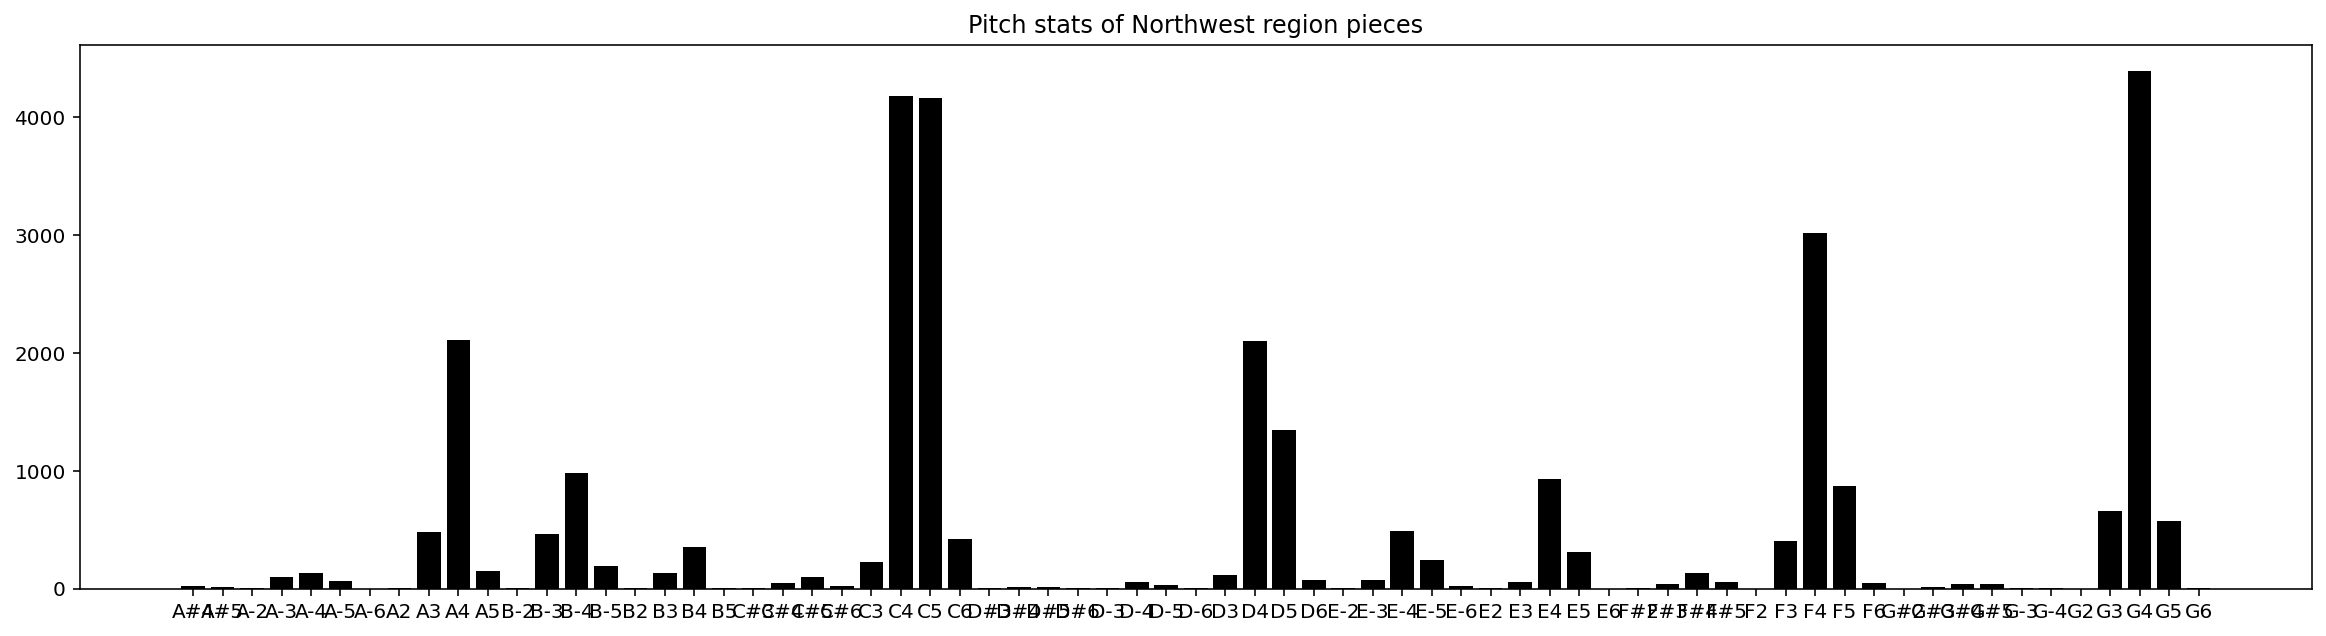

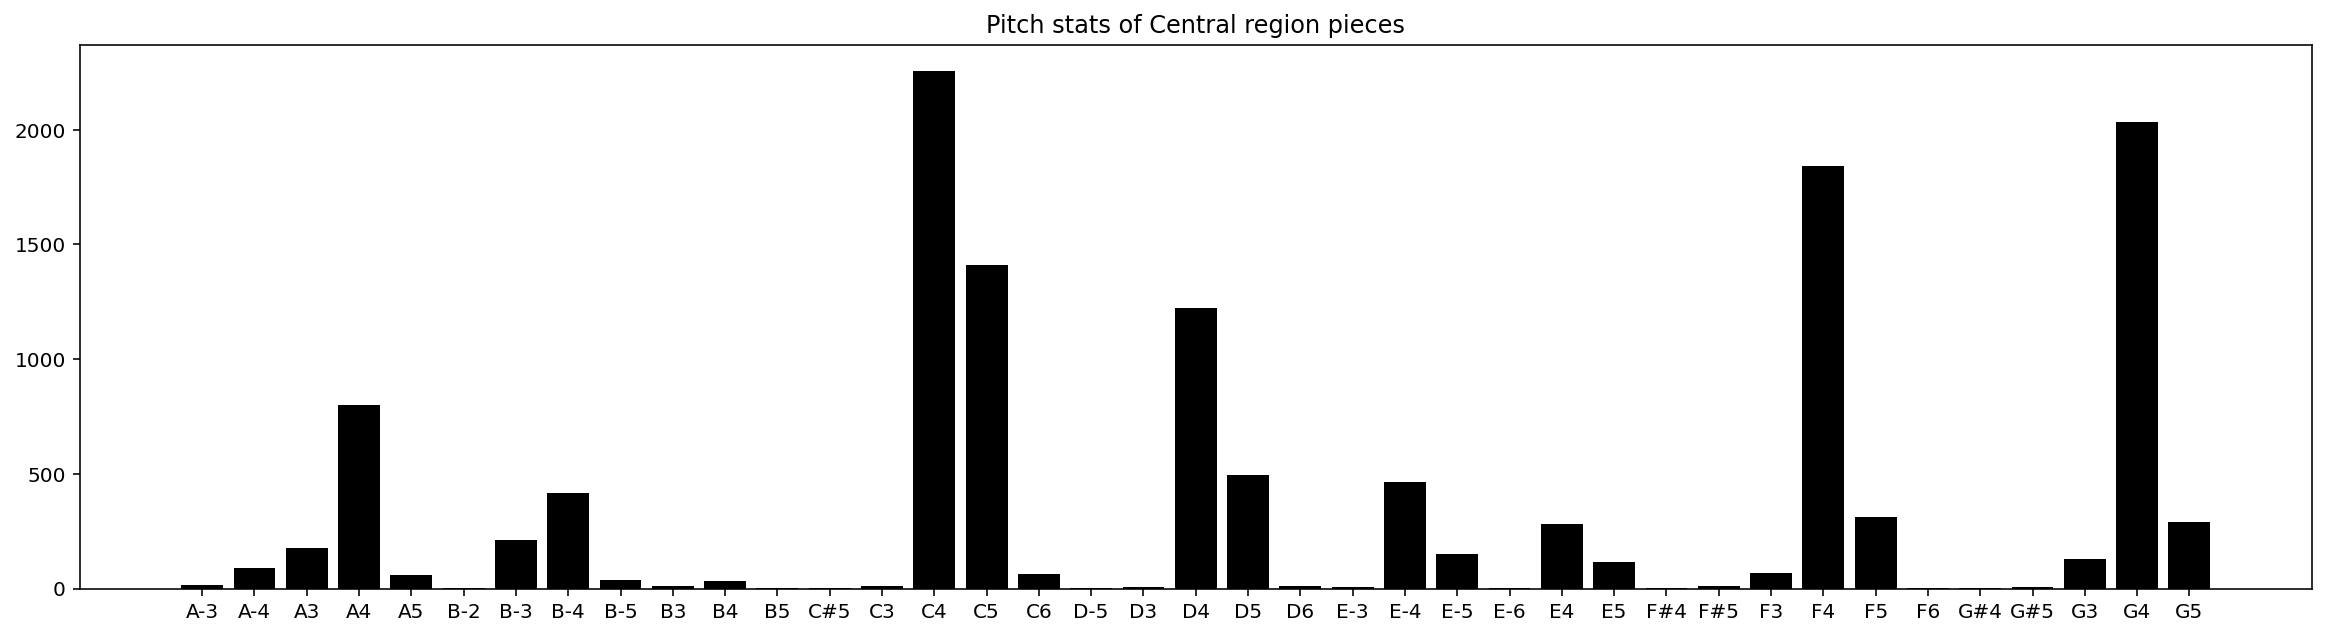

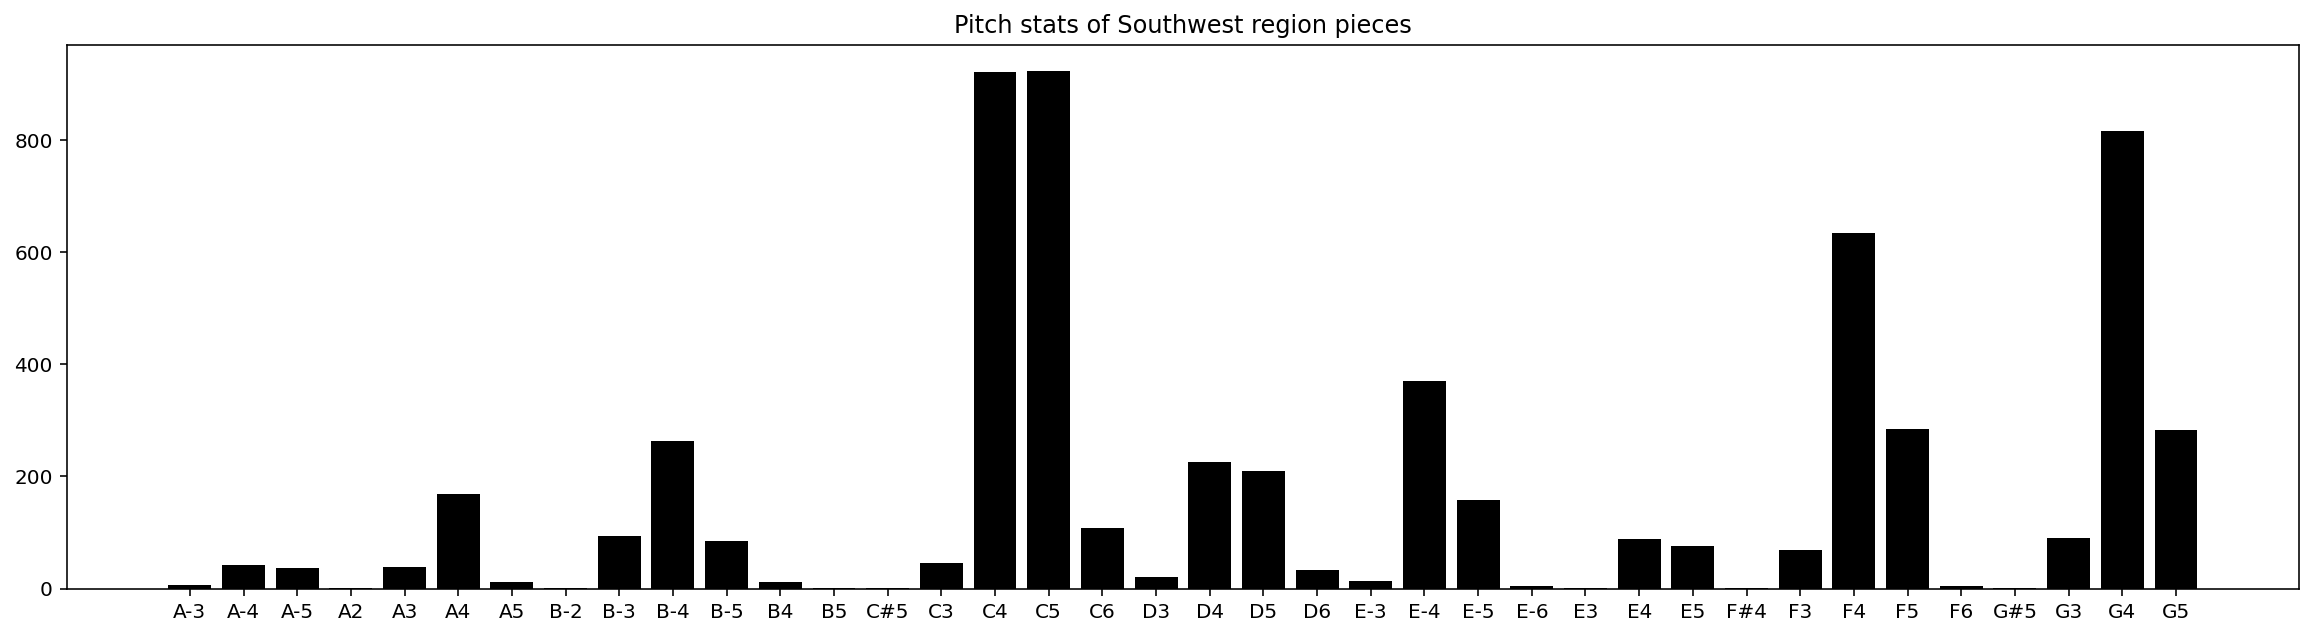

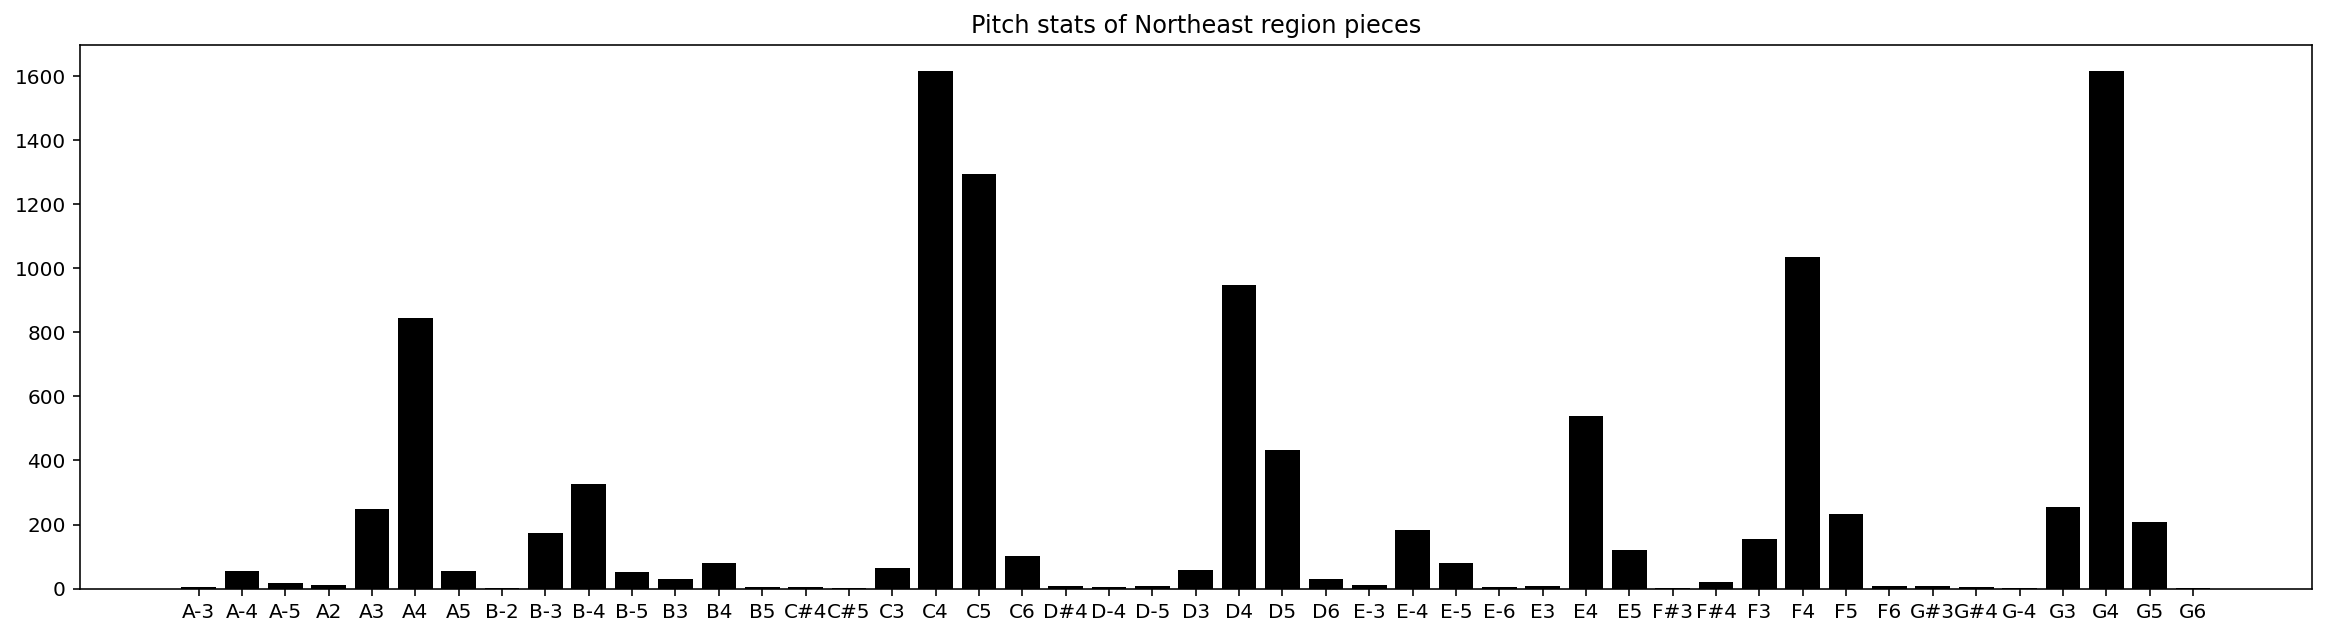

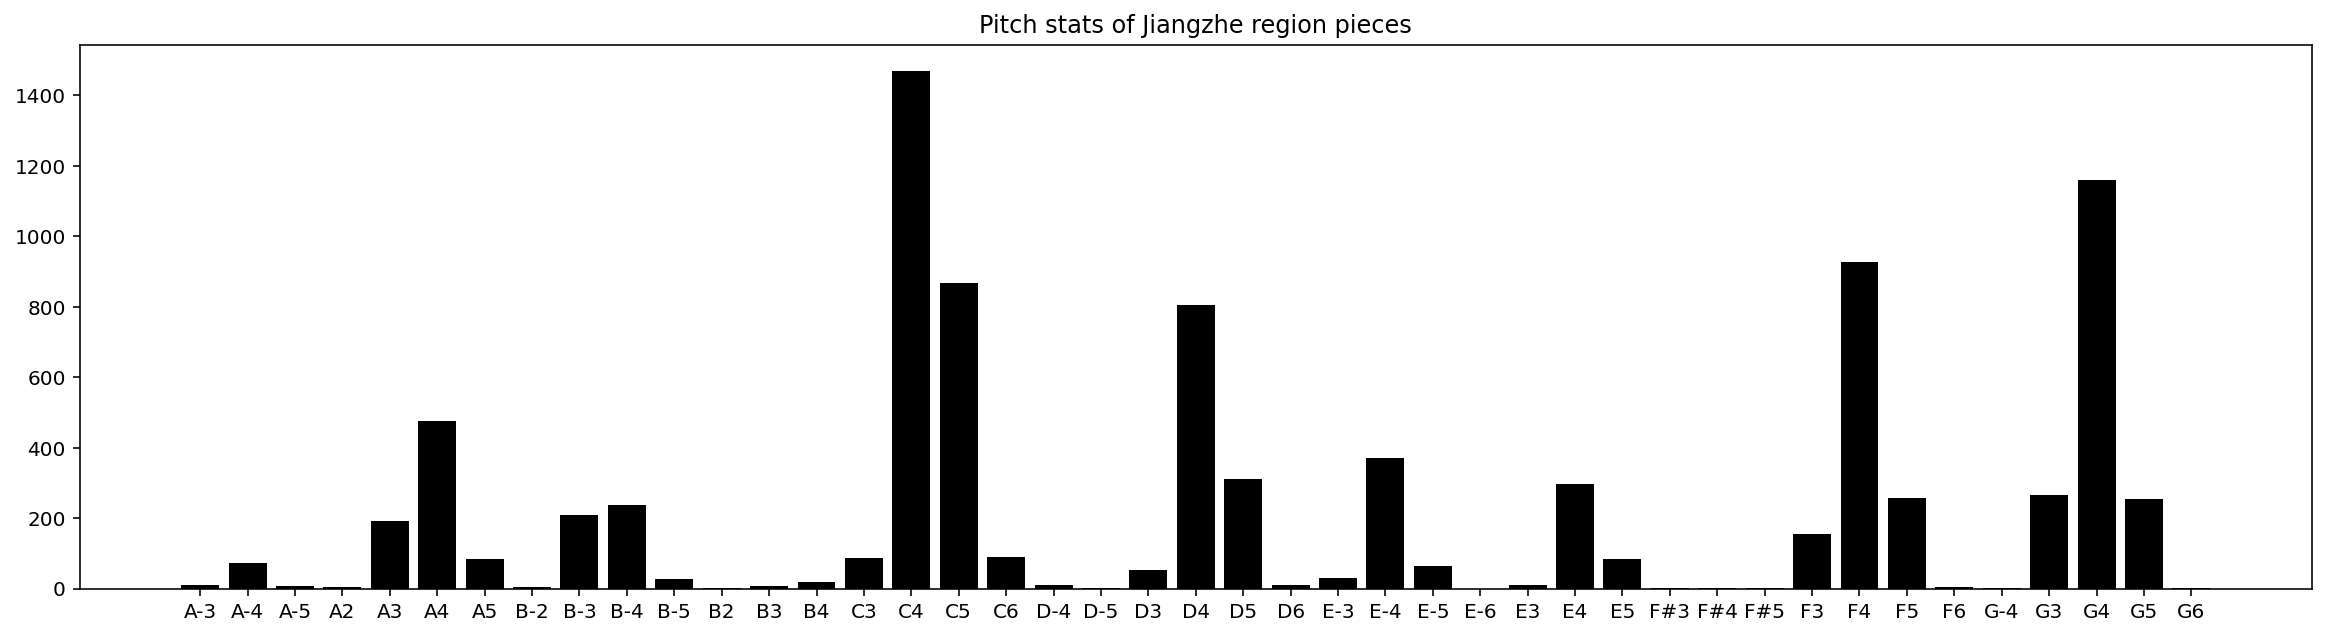

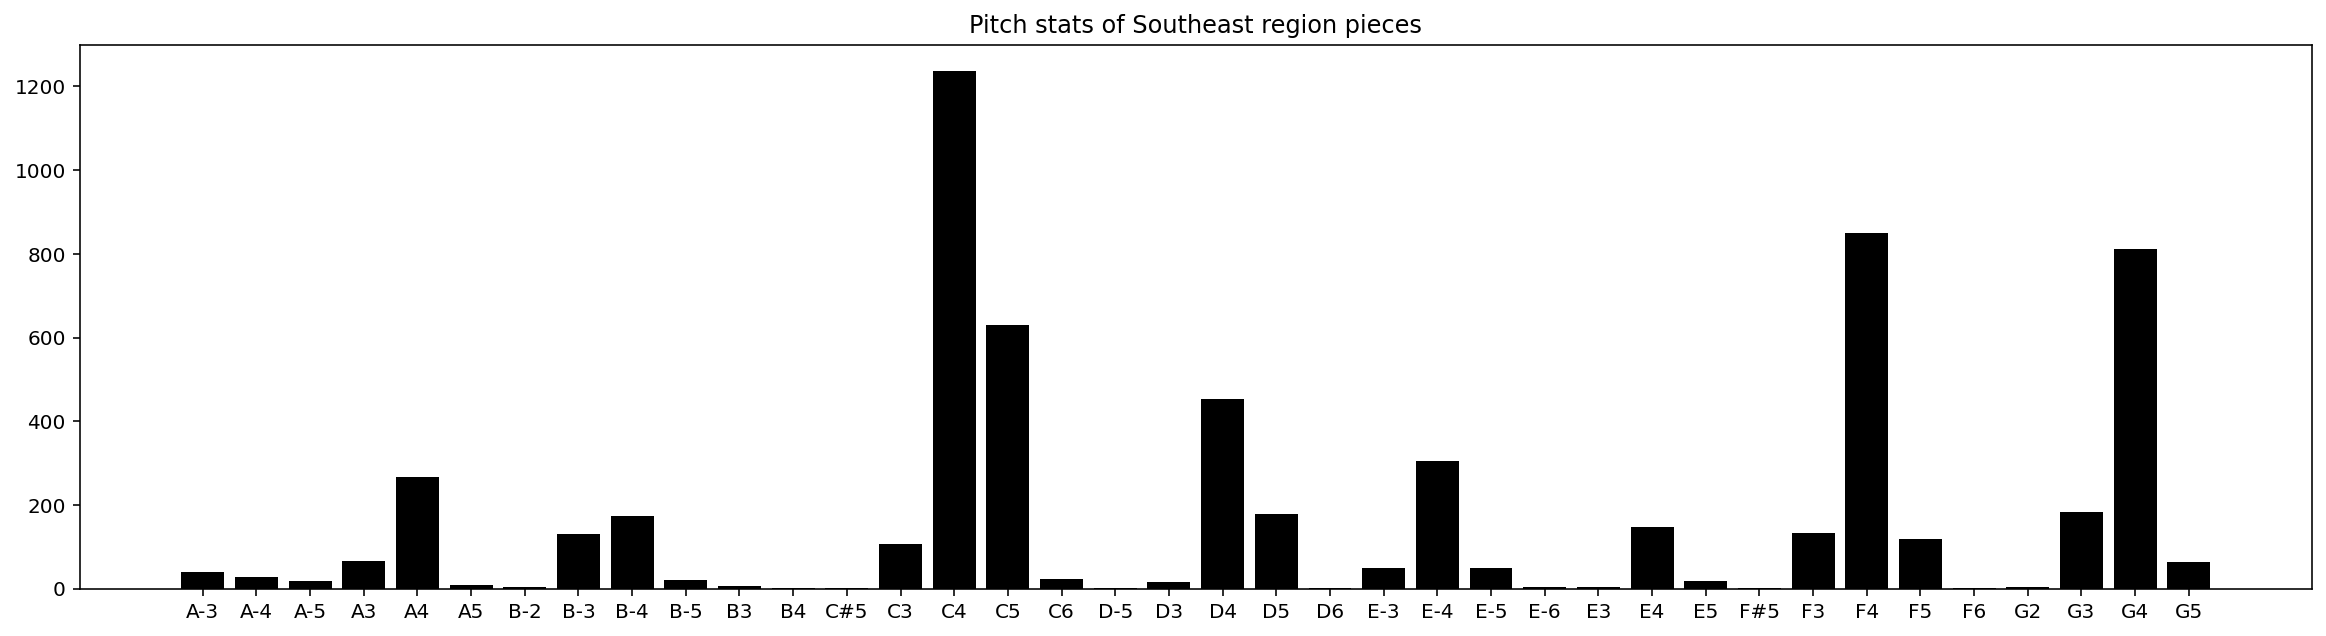

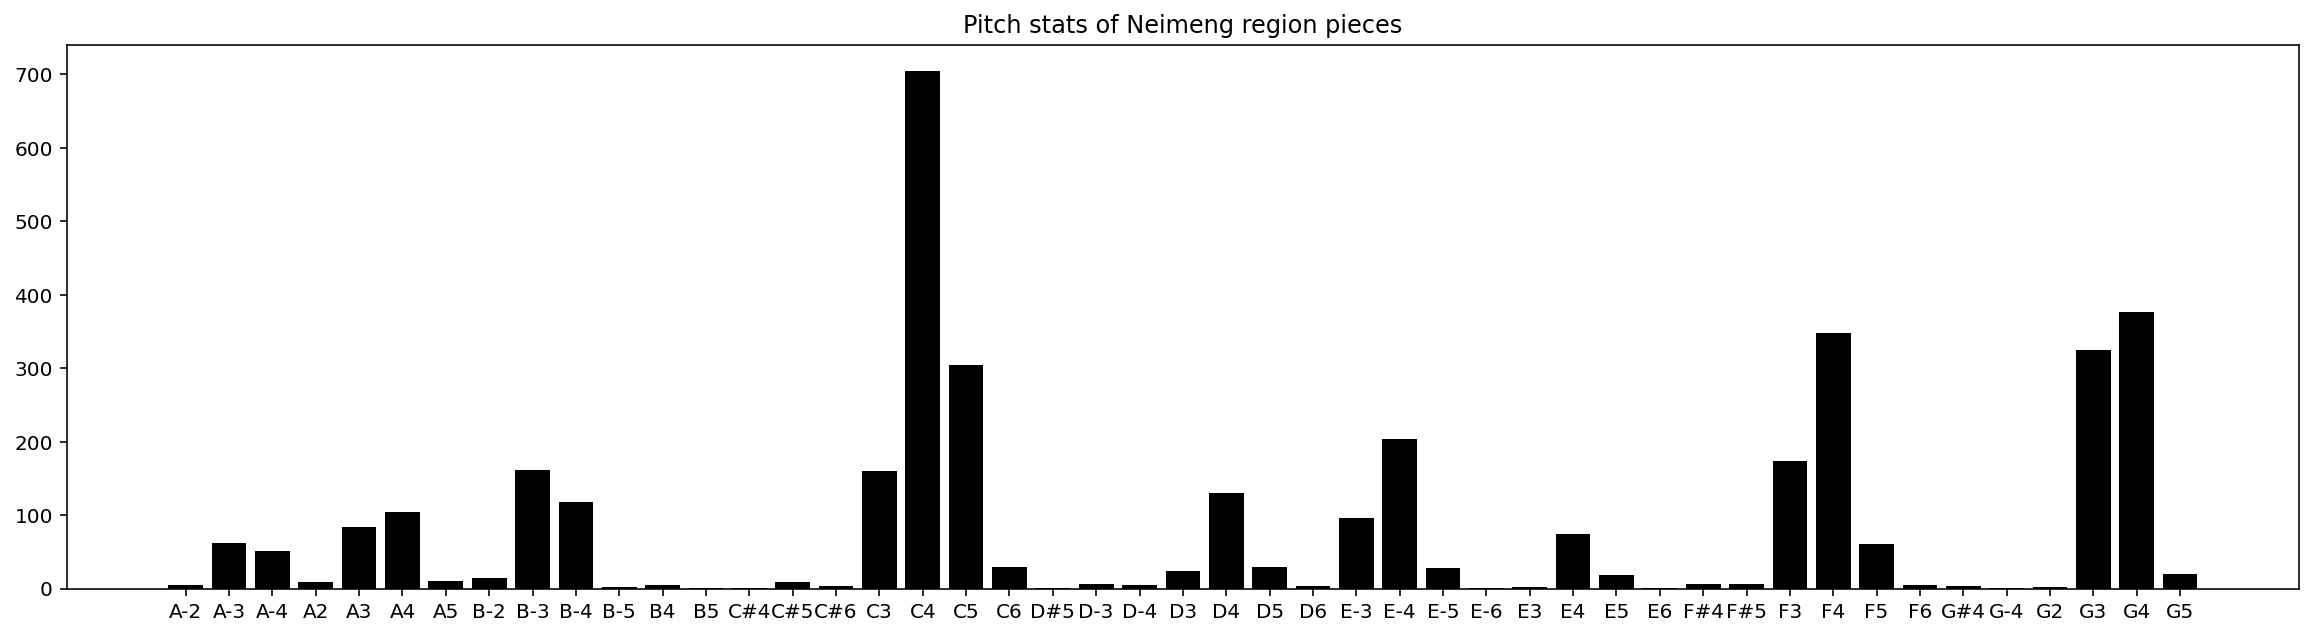

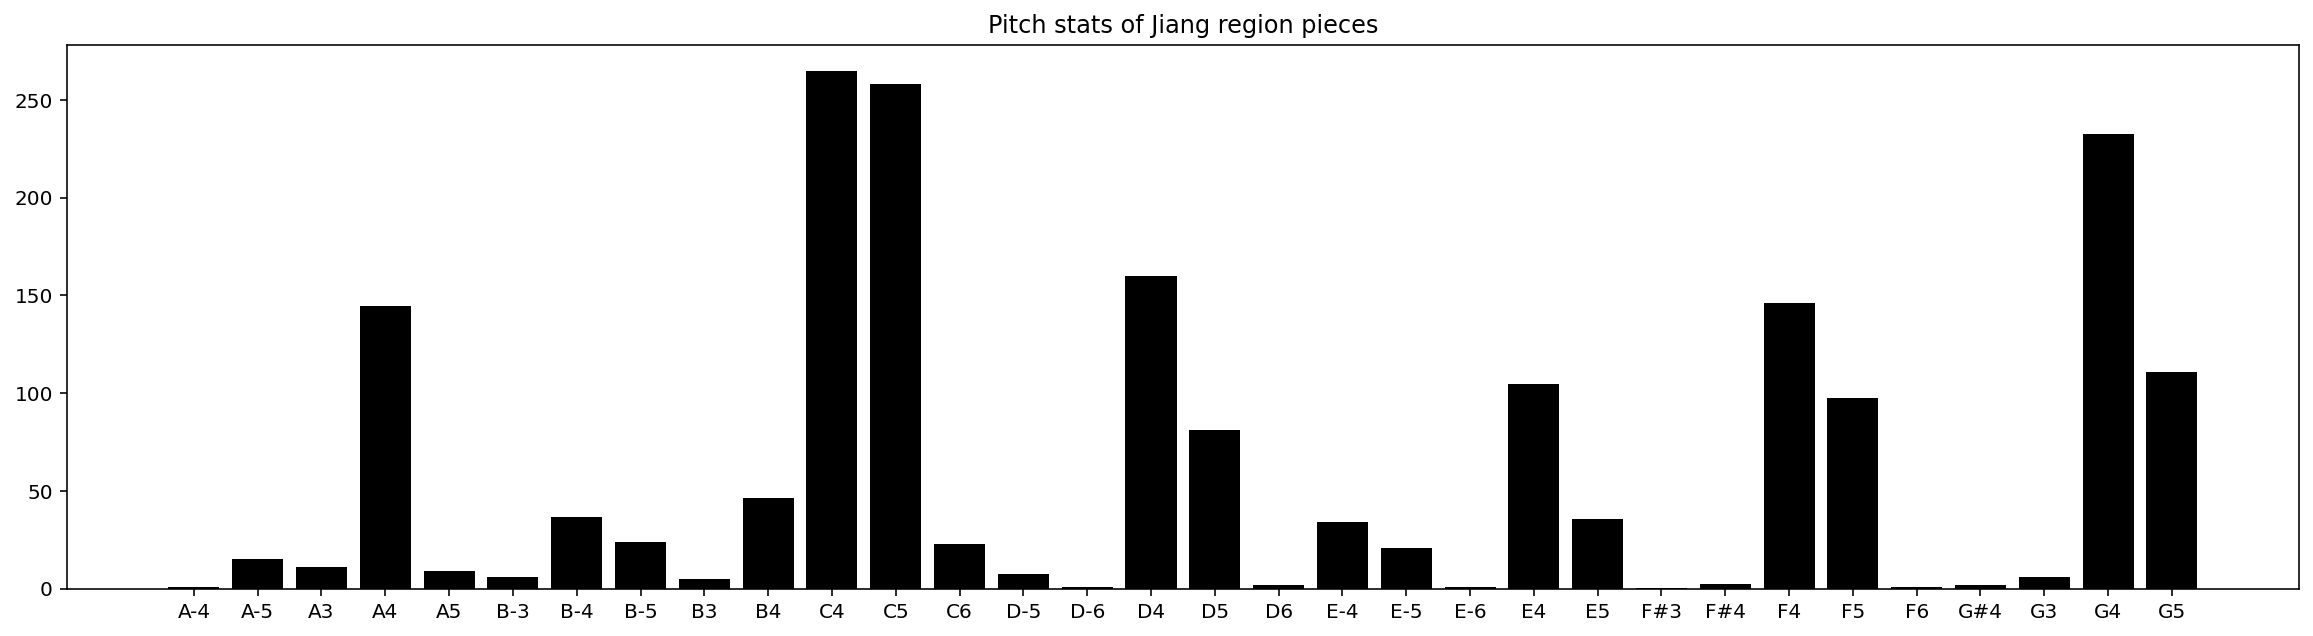

In [16]:
plt.rcParams["figure.figsize"] = (20,5)

region_pitch_transposed_met_counts = {}
for gloc in region_pitch_transposed_stat_met:
    
    counter = Counter(region_pitch_transposed_stat_met[gloc])
#     pitch_fractions = {i:counter[i] / len(region_pitch_transposed_stat_met[gloc]) for i in counter}
    pitch_fractions = {i:counter[i] for i in counter}
    region_pitch_transposed_met_counts[gloc] = sorted(pitch_fractions.items(), key=lambda pair: pair[0])
    
    x, y = zip(*region_pitch_transposed_met_counts[gloc])
    
    plt.bar(x, y, color='black')
    plt.title("Pitch stats of {} region pieces".format(gloc))
    plt.show()

### Scale Degree statistics (with metrical information)

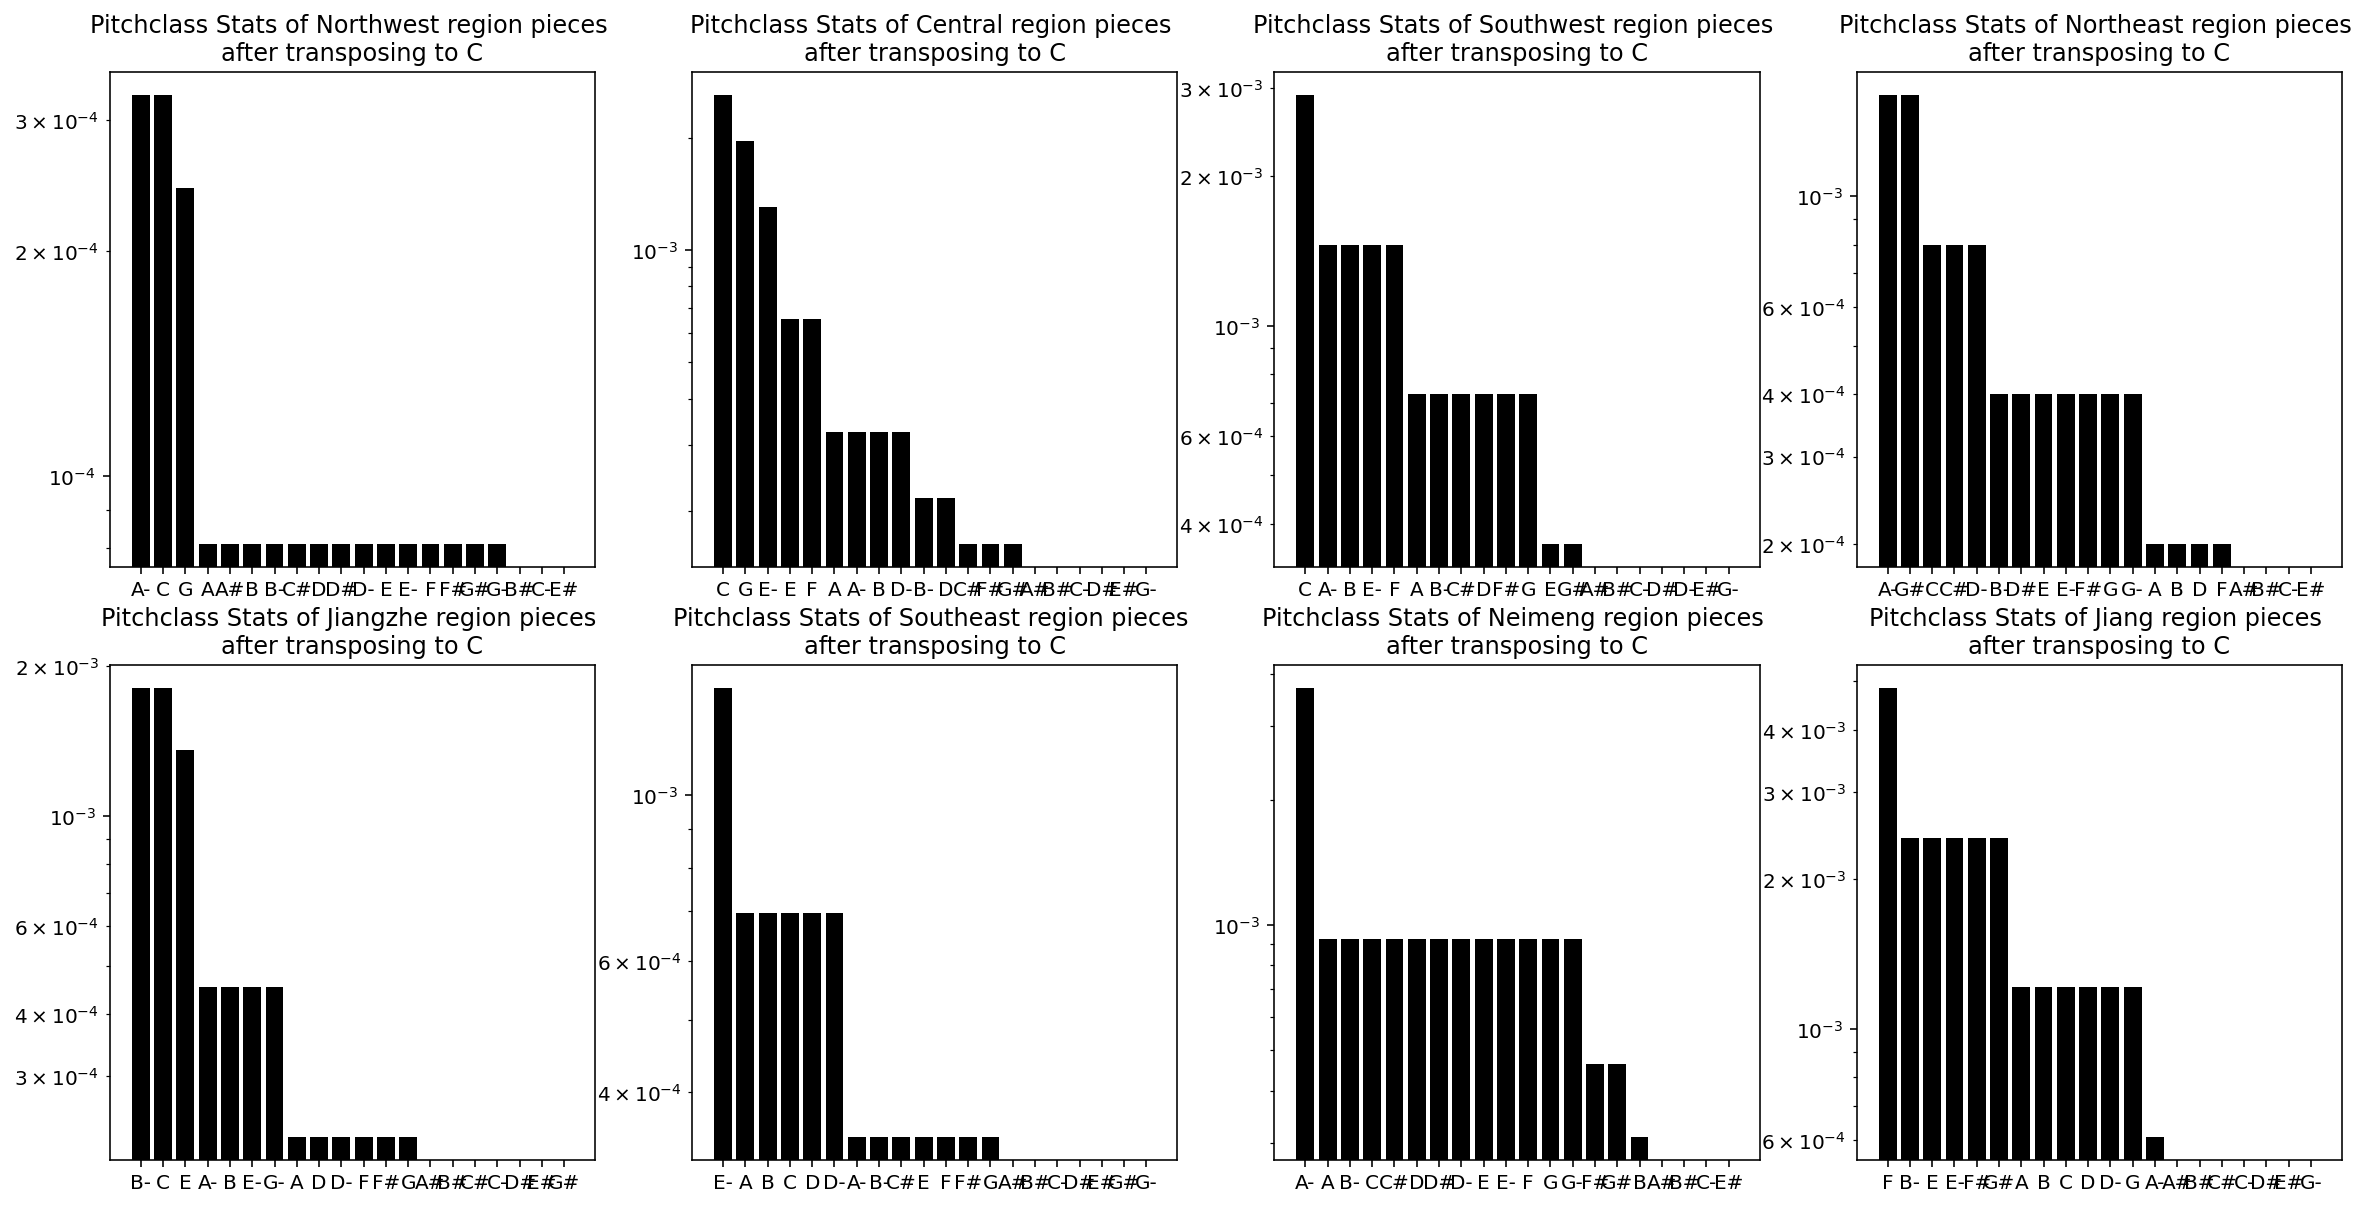

In [22]:
plt.rcParams["figure.figsize"] = (20, 10)
fig, axarr = plt.subplots(2,4)
region_scaledegree_transposed_met_counts = {}

for gloc, ax in zip(region_scaledegree_transposed_stat_met, axarr.flat):
    
    counter = Counter(region_scaledegree_transposed_stat_met[gloc])
    scaledegree_transposed_fractions_met = {i:counter[i] / len(region_scaledegree_transposed_stat[gloc]) for i in counter}
#     scaledegree_transposed_fractions_met = {i:counter[i] for i in counter}
    scaledegree_transposed_fractions_met = {**scaledegree_defcount, **scaledegree_transposed_fractions_met}
    region_scaledegree_transposed_met_counts[gloc] = sorted(scaledegree_transposed_fractions_met.items(), key=lambda pair: -pair[1])
    x, y = zip(*region_scaledegree_transposed_met_counts[gloc])
    ax.bar(x, y, color='black')
    ax.set_yscale('log')
    ax.set_title("Pitchclass Stats of {} region pieces \nafter transposing to C".format(gloc))

### Pitch Classes Transitions (with metrical information)

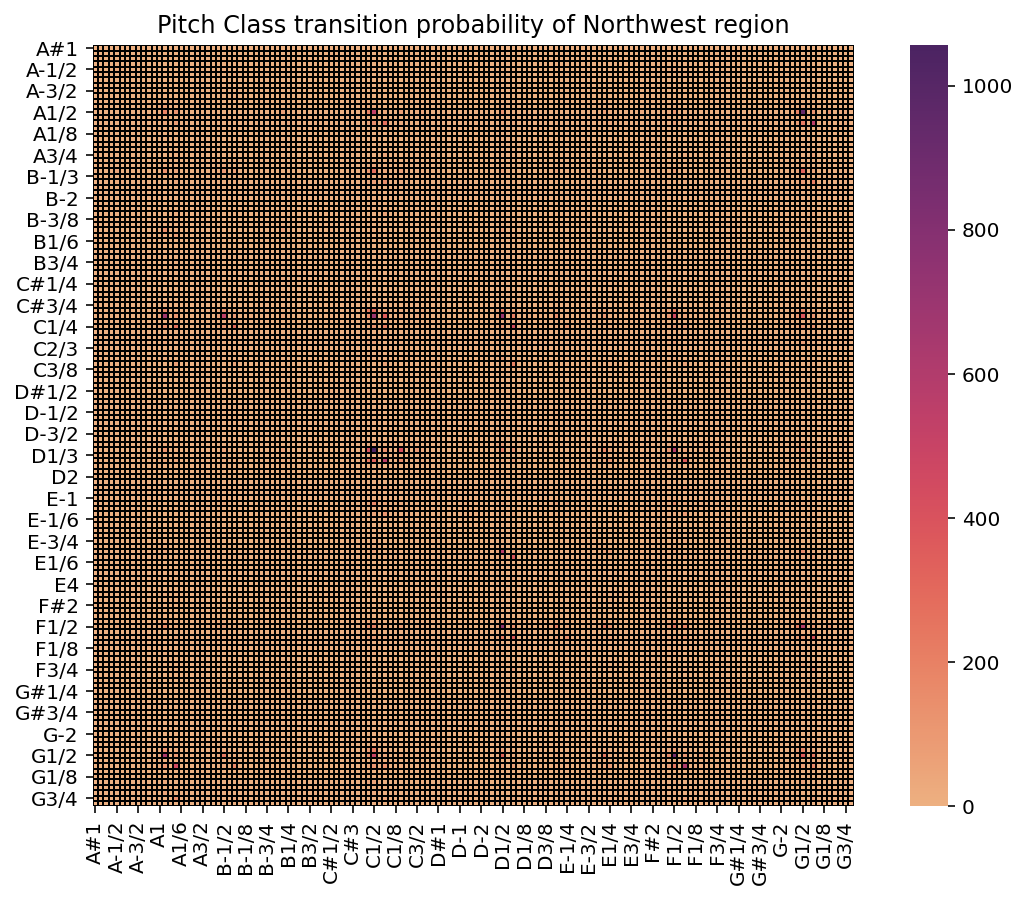

----------------------------------------------------------------------------------------------------------------------------------------------------------------


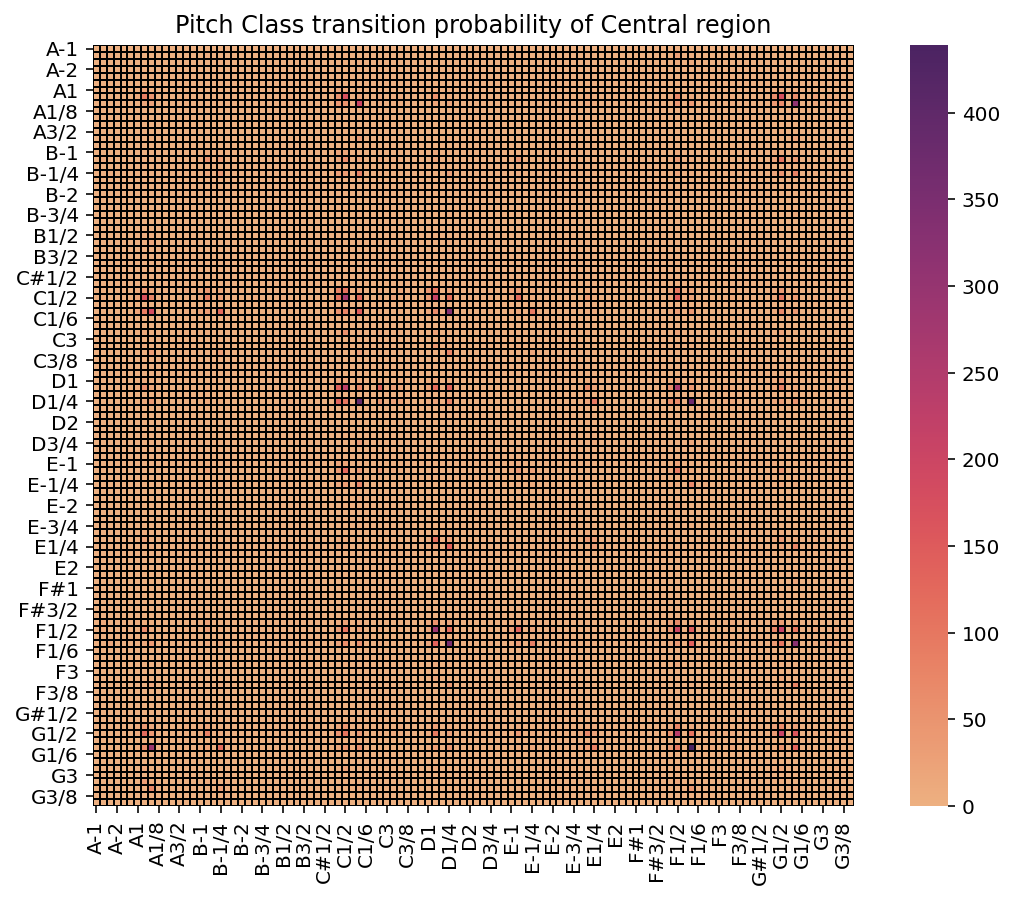

----------------------------------------------------------------------------------------------------------------------------------------------------------------


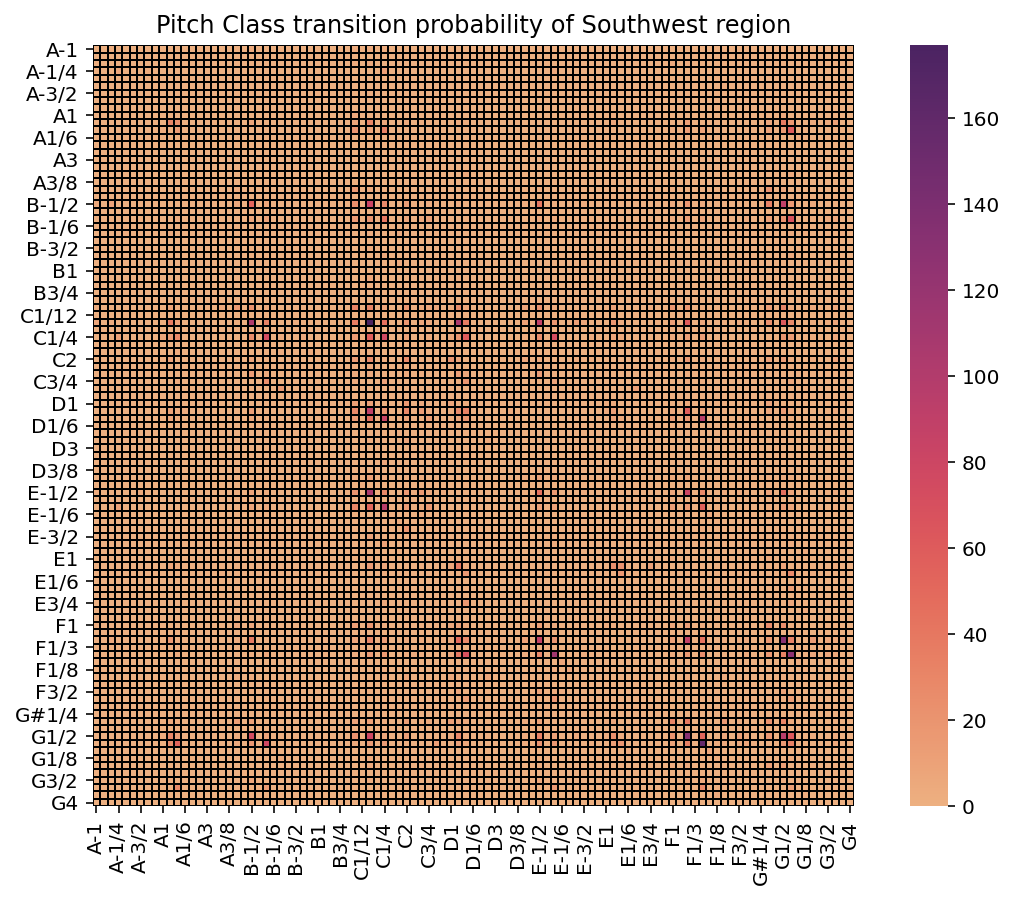

----------------------------------------------------------------------------------------------------------------------------------------------------------------


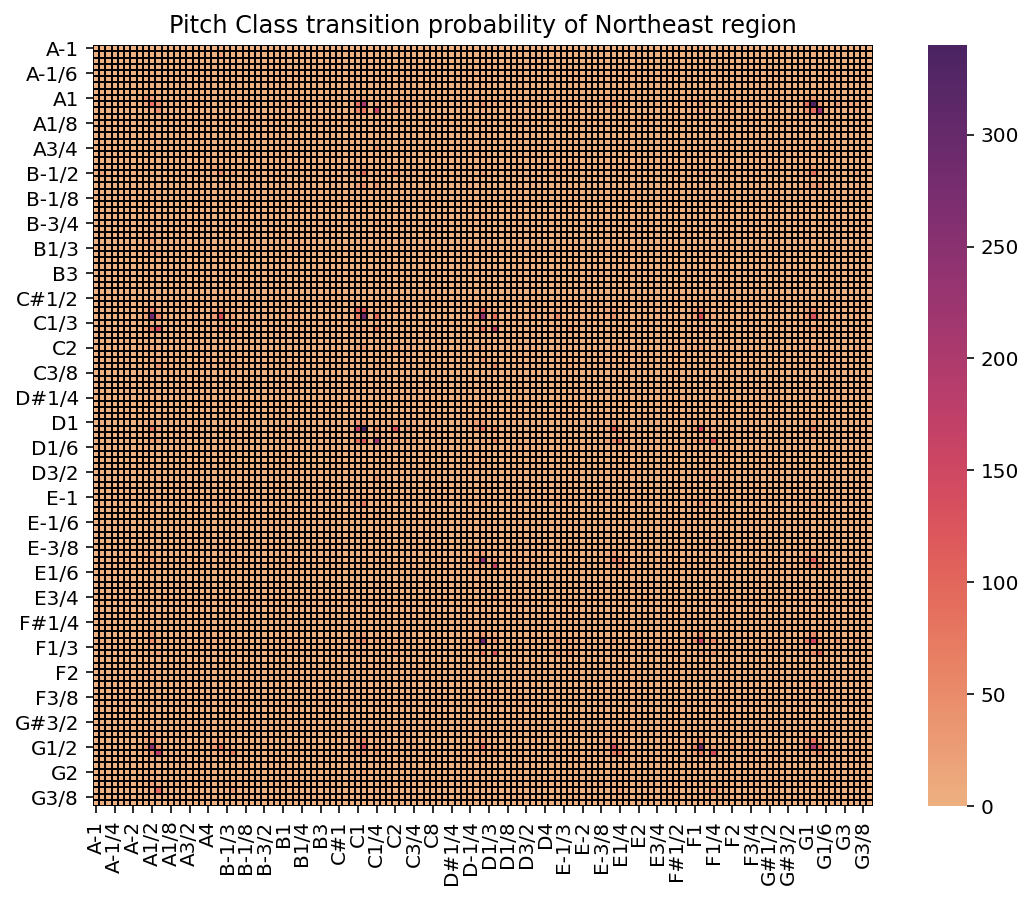

----------------------------------------------------------------------------------------------------------------------------------------------------------------


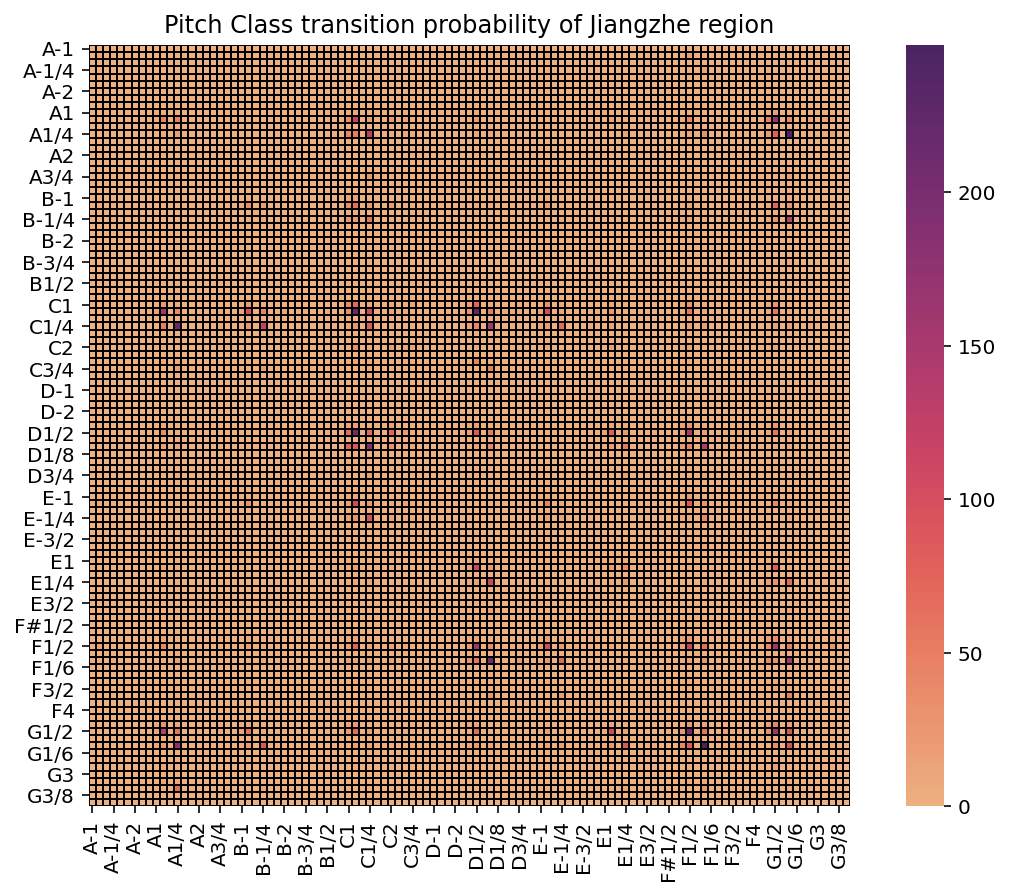

----------------------------------------------------------------------------------------------------------------------------------------------------------------


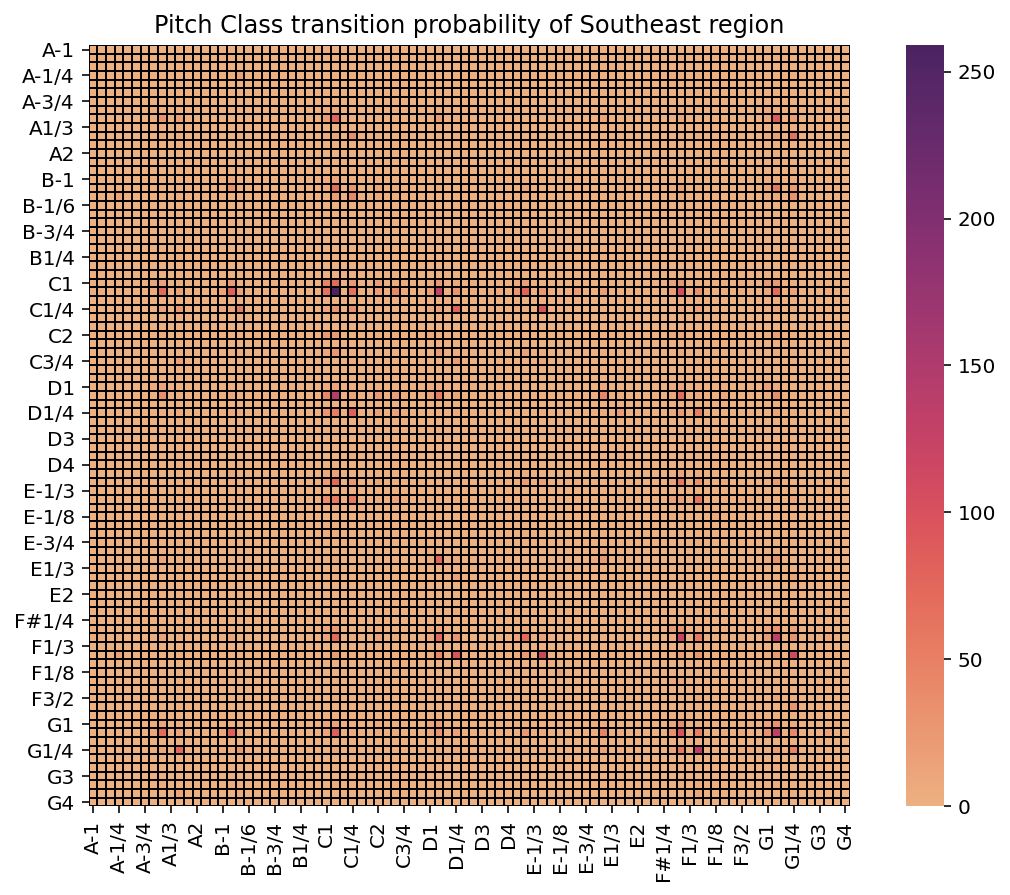

----------------------------------------------------------------------------------------------------------------------------------------------------------------


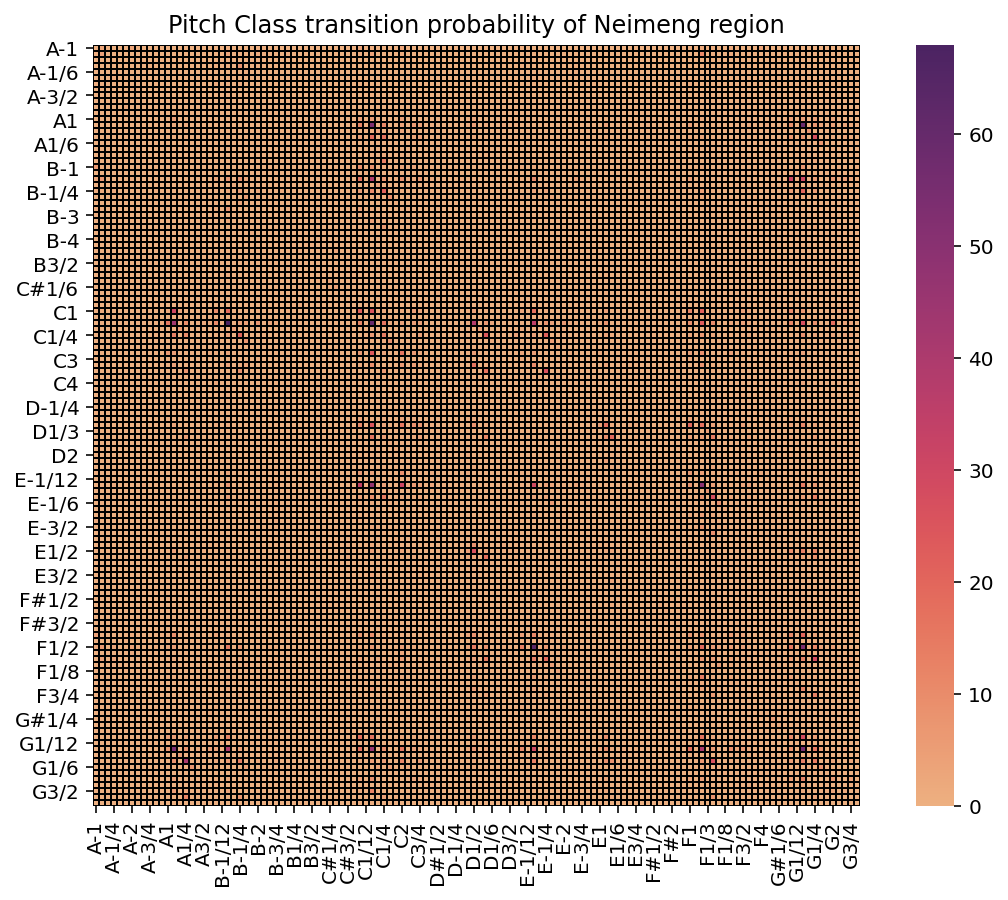

----------------------------------------------------------------------------------------------------------------------------------------------------------------


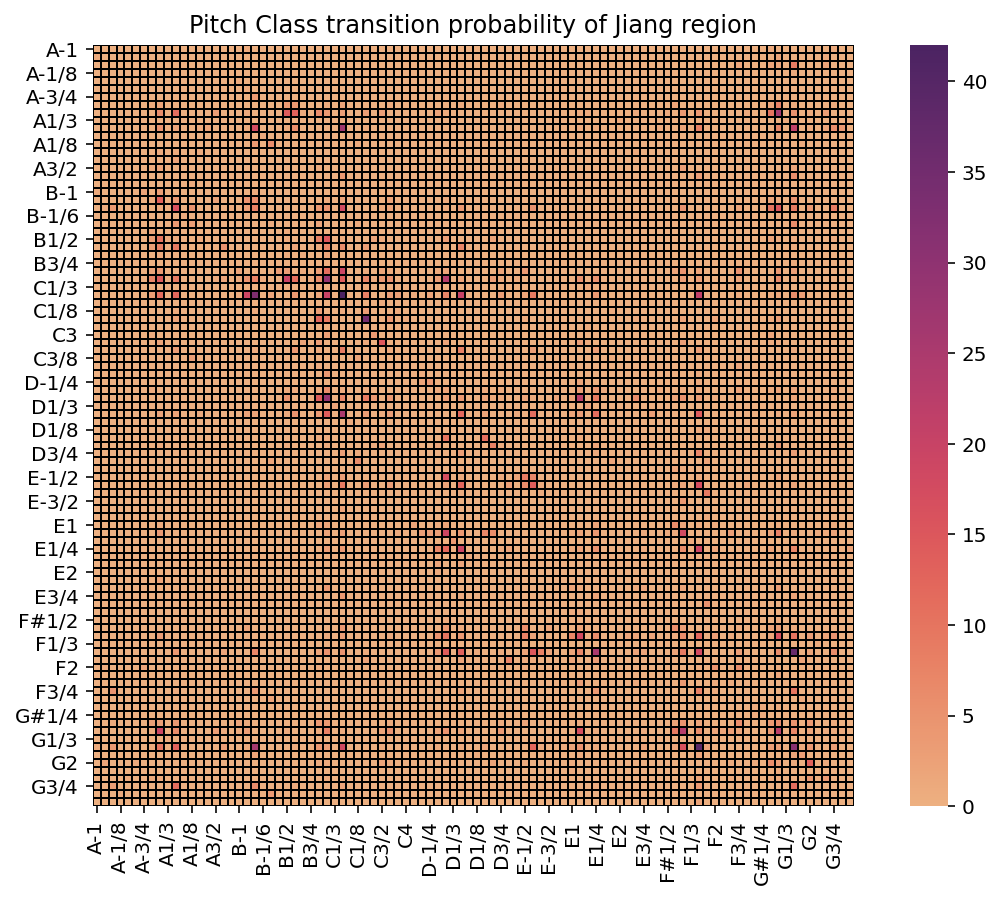

----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [24]:
plt.rcParams["figure.figsize"] = (10, 7)
colormap = sns.color_palette("flare", as_cmap=True)
for gloc in geo_divisions:
    fig, axes = plt.subplots(1,1)
    
    sorted_probs = sort_dict(pitchclass_transition_met[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax1 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    axes = ax1
    ax1.set_title("Pitch Class transition probability of {} region".format(gloc))
    plt.show()
    
    print("--"*80)

### Interval Transitions (with metrical information)

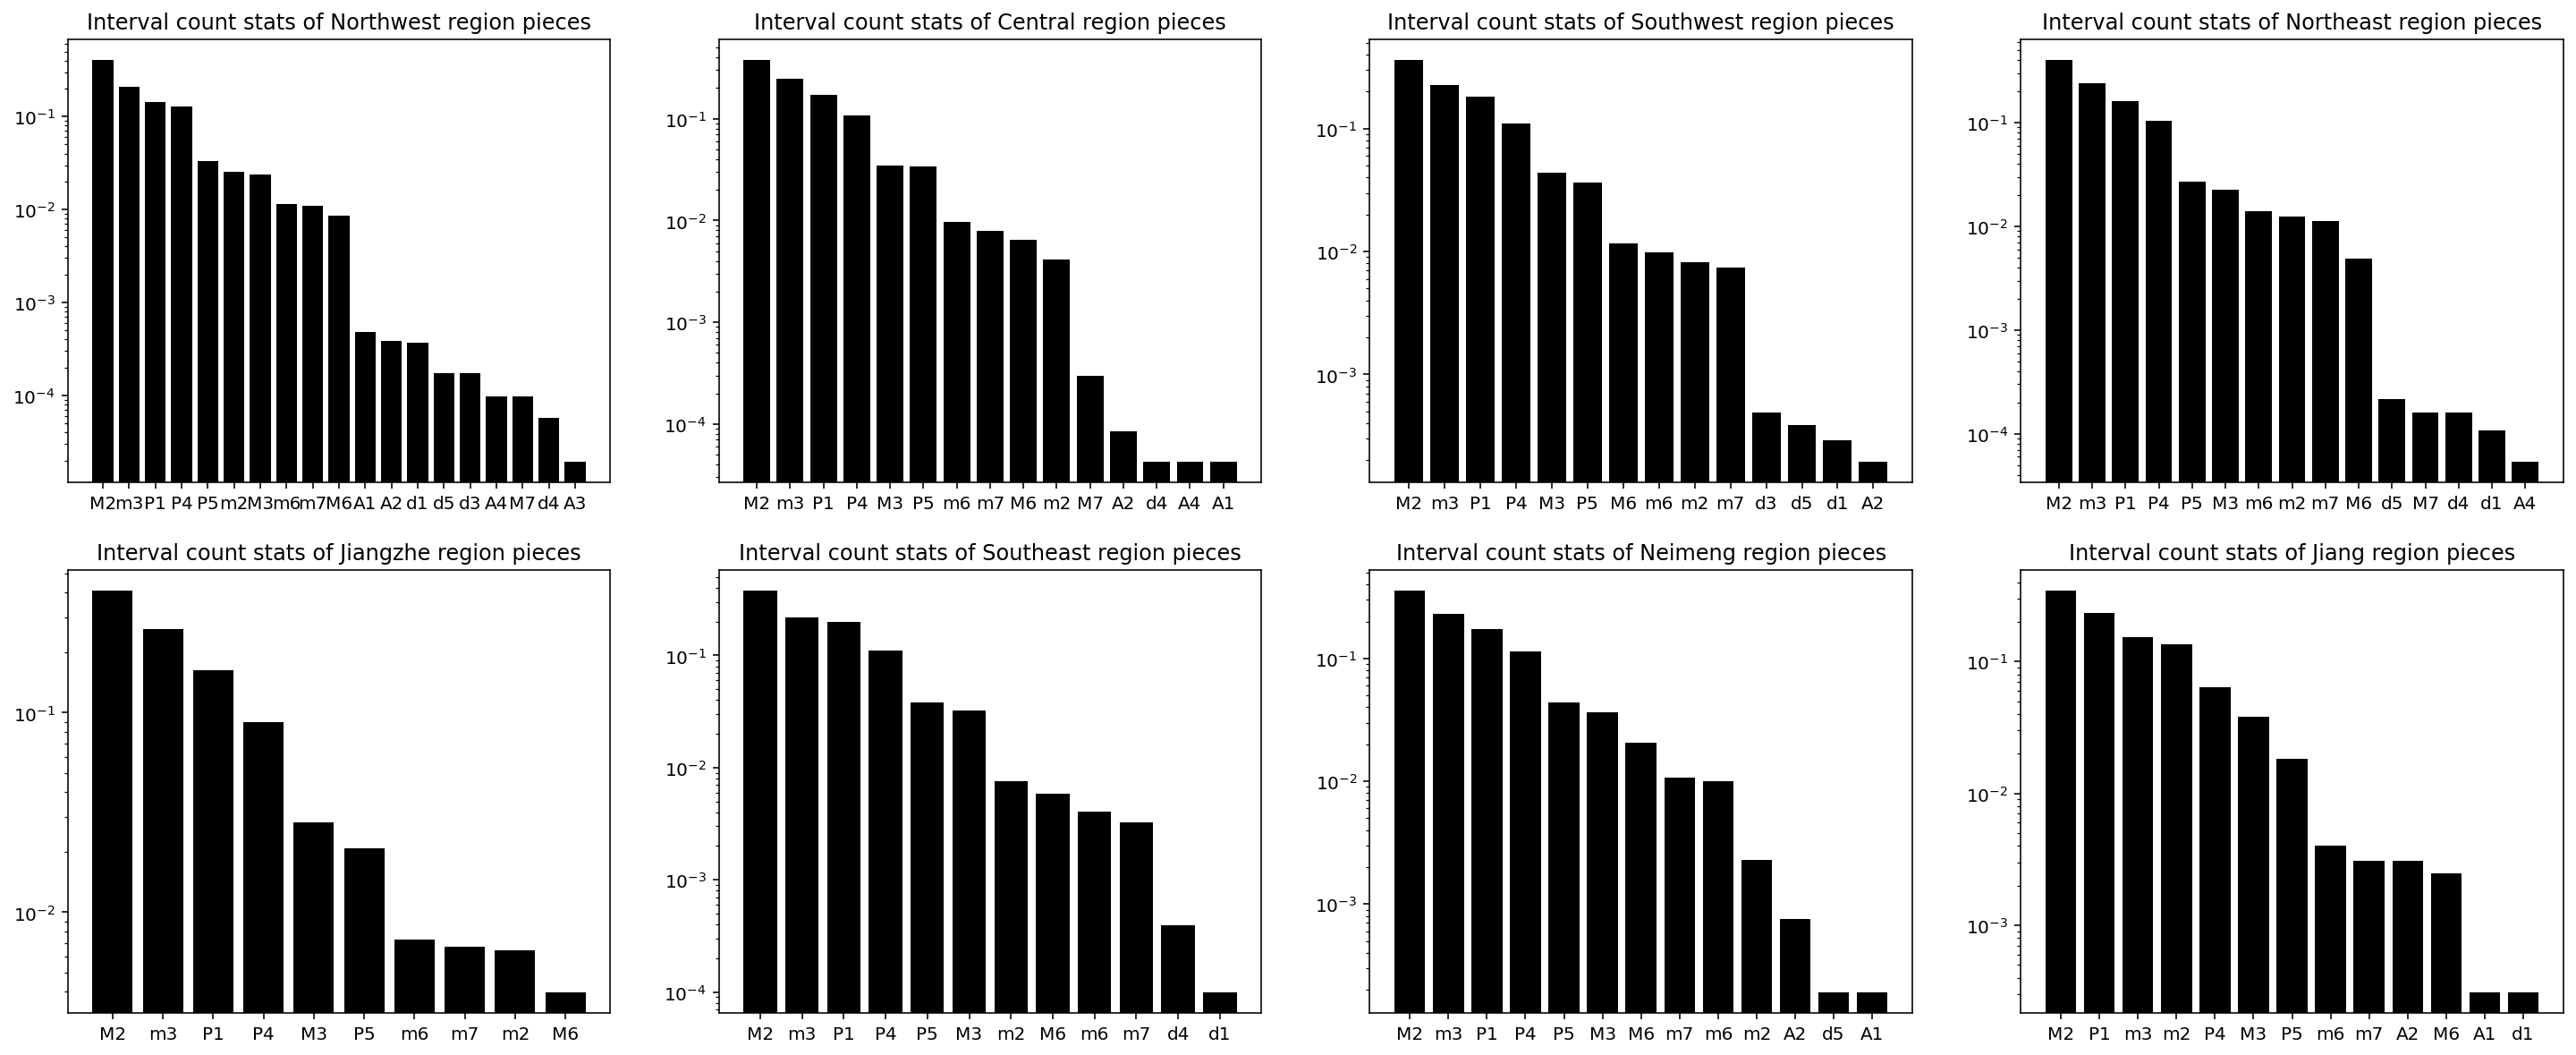

In [25]:
plt.rcParams["figure.figsize"] = (25, 10)
fig, axarr = plt.subplots(2,4)

for division_name, ax in zip(interval_transition, axarr.flat):
    division_intervals = interval_transition[division_name]
    # get values in the same order as keys
    total_interval_count = sum(division_intervals.values())
    interval_fractions = {i:division_intervals[i] / total_interval_count for i in division_intervals}
    sorted_interval_fractions = {k: v for k, v in sorted(interval_fractions.items(), key=lambda item:-item[1])}
    x = (sorted_interval_fractions.keys())
    y = (sorted_interval_fractions.values())
    ax.bar(x, y, color='black')
    ax.set_yscale('log')
    ax.set_title("Interval count stats of {} region pieces".format(division_name))